# 준비

In [2]:
!pip install pydicom
!pip install pydicom transformers torch torchvision clip-by-openai
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision torchaudio
!pip install transformers
!apt update
!apt install -y libgl1-mesa-glx
!pip install scikit-image

  Using cached pydicom-3.0.1-py3-none-any.whl.metadata (9.4 kB)
Using cached pydicom-3.0.1-py3-none-any.whl (2.4 MB)
  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached clip_by_openai-1.1-py3-none-any.whl.metadata (369 bytes)
  Using cached huggingface_hub-0.29.1-py3-none-any.whl.metadata (13 kB)
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached clip_by_openai-1.0.1-py3-none-any.whl.metadata (407 bytes)
  Using cached clip_by_openai-0.1.1.5-py3-none-any.whl.metada

In [3]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns

In [4]:
import glob

L_list = glob.glob('/root/mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list = [path for path in L_list if 'L' in path]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

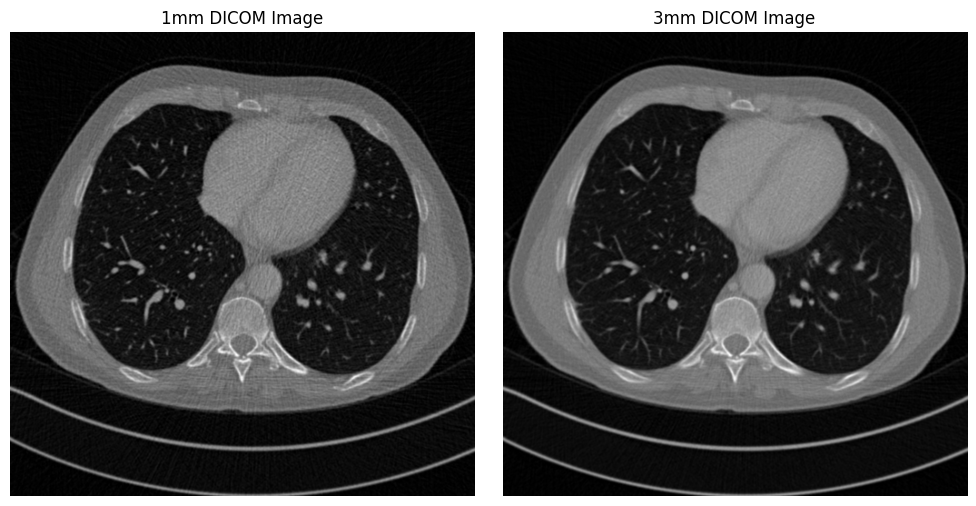

In [5]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import glob

# L_list에서 첫 번째 값 가져오기
L = L_list[0]

# 1mm 및 3mm DICOM 파일 경로 설정
path1mm = sorted(glob.glob(f'/root/mayo2016/{L}/quarter_1mm/*.IMA'))[0]
path3mm = sorted(glob.glob(f'/root/mayo2016/{L}/quarter_3mm/*.IMA'))[0]

# DICOM 파일 읽기
dicom_data_1mm = pydicom.dcmread(path1mm)
dicom_data_3mm = pydicom.dcmread(path3mm)

# 픽셀 데이터 추출 및 정규화
img1mm = dicom_data_1mm.pixel_array.astype(np.float32)
img3mm = dicom_data_3mm.pixel_array.astype(np.float32)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img1mm, cmap='gray')
axes[0].set_title('1mm DICOM Image')
axes[0].axis('off')

axes[1].imshow(img3mm, cmap='gray')
axes[1].set_title('3mm DICOM Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


📌 결론: 1mm vs. 3mm, 어떤 것이 더 적합할까?

✅ 1mm 데이터를 추천

목적이 정밀한 디노이징 및 세그멘테이션을 위한 모델 개발이라면, 1mm를 선택하는 것이 좋음
노이즈가 많지만, 실제 저선량 CT에서 발생하는 복원 문제를 더 잘 반영할 수 있음
다만, 1mm는 더 어려운 문제이므로 데이터 증강이나 추가적인 노이즈 제거 기법을 고려하는 것이 필요

✅ 3mm는 빠르고 안정적인 학습이 필요할 때 사용 가능

초기 실험에서는 3mm로 시작하여 모델의 기본적인 성능을 확인하고, 이후 1mm 데이터로 파인튜닝하는 전략도 가능

In [6]:
# 1mm 사용함

data_label = ['quarter_1mm', 'full_1mm']

In [7]:
# # X,y의 순서쌍 갯수가 일치한다.

# for L in L_list:
#   n1 = len(sorted(glob.glob(f'/root/mayo2016/{L}/{data_label[0]}/*.IMA')))
#   n2 = len(sorted(glob.glob(f'/root/mayo2016/{L}/{data_label[0]}/*.IMA')))
#   notation = ''
#   if n1 != n2:
#     notation = '<-'
#   print(f"{L} : {n1}, {n2} {notation}")

In [8]:
# # 모든 이미지가 512x512 사이즈이다.

# for L in L_list:
#   for label in data_label:
#     path_list = sorted(glob.glob(f'/root/mayo2016/{L}/{label}/*.IMA'))
#     for file_path in path_list:
#         dicom_data = pydicom.dcmread(file_path)
#         img = dicom_data.pixel_array
#         assert img.shape == (512, 512)

# 전처리

## 1. 부위 종류 확인

### 시각화

In [9]:
import os
import pydicom
import numpy as np
import torch
import clip
from torchvision import transforms
from PIL import Image

# 이미지 불러오기
def load_dicom_image(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32)

    # 정규화 (0~1 사이로)
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)

    return Image.fromarray(img)

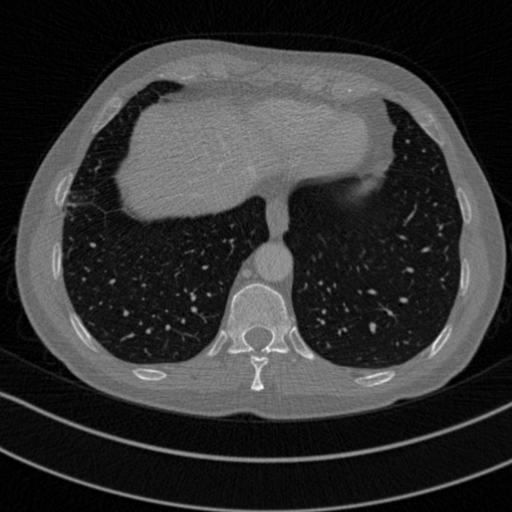

In [10]:
# Mayo 2016 데이터셋에서 DICOM 파일 찾기
base_folder = "/root/mayo2016"
img_type = "quarter_1mm"
dicom_files = []

# 모든 L0xx 폴더에서 DICOM 파일 수집
L_patients = L_list
for patient_id in L_patients:
    patient_folder = os.path.join(base_folder, patient_id, "quarter_1mm") # quarter_1mm
    if os.path.exists(patient_folder):
        patient_files = [os.path.join(patient_folder, f) 
                        for f in os.listdir(patient_folder) 
                        if f.endswith(".IMA")]
        dicom_files.extend(patient_files)

# 첫 번째 DICOM 이미지를 로드
dicom_img = load_dicom_image(dicom_files[0])
dicom_img.show()  # 시각화

### clip 사용하기

In [9]:
import clip
import torch

# PubMedCLIP 모델 불러오기
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

print("CLIP 모델 로드 성공!")

CLIP 모델 로드 성공!


In [10]:
import clip
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)  # 일반 CLIP 모델 사용 (PubMedCLIP 버전이 필요하면 따로 다운로드)

# 이미지 변환
image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

# 장기 검색을 위한 텍스트
text_descriptions = [
    "brain",          # 뇌
    "lungs",          # 폐
    "liver",          # 간
    "stomach",        # 위
    "kidneys",        # 신장
    "pancreas",       # 췌장
    "spleen",         # 비장
    "heart",          # 심장
    "chest",          # 가슴 (흉부)
    "abdomen",        # 복부
    "pelvis",         # 골반
    "spine",          # 척추
    "ribs",           # 갈비뼈
    "bladder",        # 방광
    "prostate",       # 전립선 (남성)
    "uterus",         # 자궁 (여성)
    "adrenal glands", # 부신
    "thyroid",        # 갑상선
    "esophagus",      # 식도
    "intestines"      # 장
]
text_tokens = clip.tokenize(text_descriptions).to(device)

# 이미지 & 텍스트 인코딩
with torch.no_grad():
    image_features = model.encode_image(image_tensor)
    text_features = model.encode_text(text_tokens)

# 코사인 유사도 계산
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarities = (image_features @ text_features.T).squeeze(0)

# 가장 유사한 장기 출력
best_match_idx = similarities.argmax().item()
print(f"Detected Organ: {text_descriptions[best_match_idx]}")

Detected Organ: lungs


In [11]:
from collections import defaultdict

# 장기별 인덱스 저장을 위한 딕셔너리 초기화
organ_indices = defaultdict(list)  # 또는 {organ: [] for organ in text_descriptions}

for idx, dicom_path in enumerate(dicom_files):  # enumerate로 인덱스 추적
    dicom_img = load_dicom_image(dicom_path)
    image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        similarities = (image_features @ text_features.T).squeeze(0)

    best_match_idx = similarities.argmax().item()
    detected_organ = text_descriptions[best_match_idx]
    
    organ_indices[detected_organ].append(idx)  # 현재 파일의 인덱스 저장

# 결과 출력 (카운트 + 인덱스 리스트)
print("Organ counts in Mayo2016 dataset:")
for organ, indices in organ_indices.items():
    print(f"{organ}: {len(indices)}")

KeyboardInterrupt: 

In [ ]:
# 특이 케이스 시각화 예시 (예: 자궁으로 분류된 첫 번째 이미지)

def drawing(anomaly_organ, idx, organ_indices=organ_indices):
    if anomaly_organ in organ_indices:
        sample_idx = organ_indices[anomaly_organ][idx]
        sample_path = dicom_files[sample_idx]
        
        import matplotlib.pyplot as plt
        dicom_img = load_dicom_image(sample_path)
        plt.imshow(dicom_img, cmap='gray')
        plt.title(f"Detected: {anomaly_organ}")
        plt.show()
    else:
        print(f"No cases detected for {anomaly_organ}.")

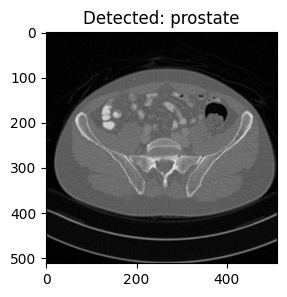

In [ ]:
anomaly_organ = "prostate"
idx = 0

drawing(anomaly_organ, idx, organ_indices)

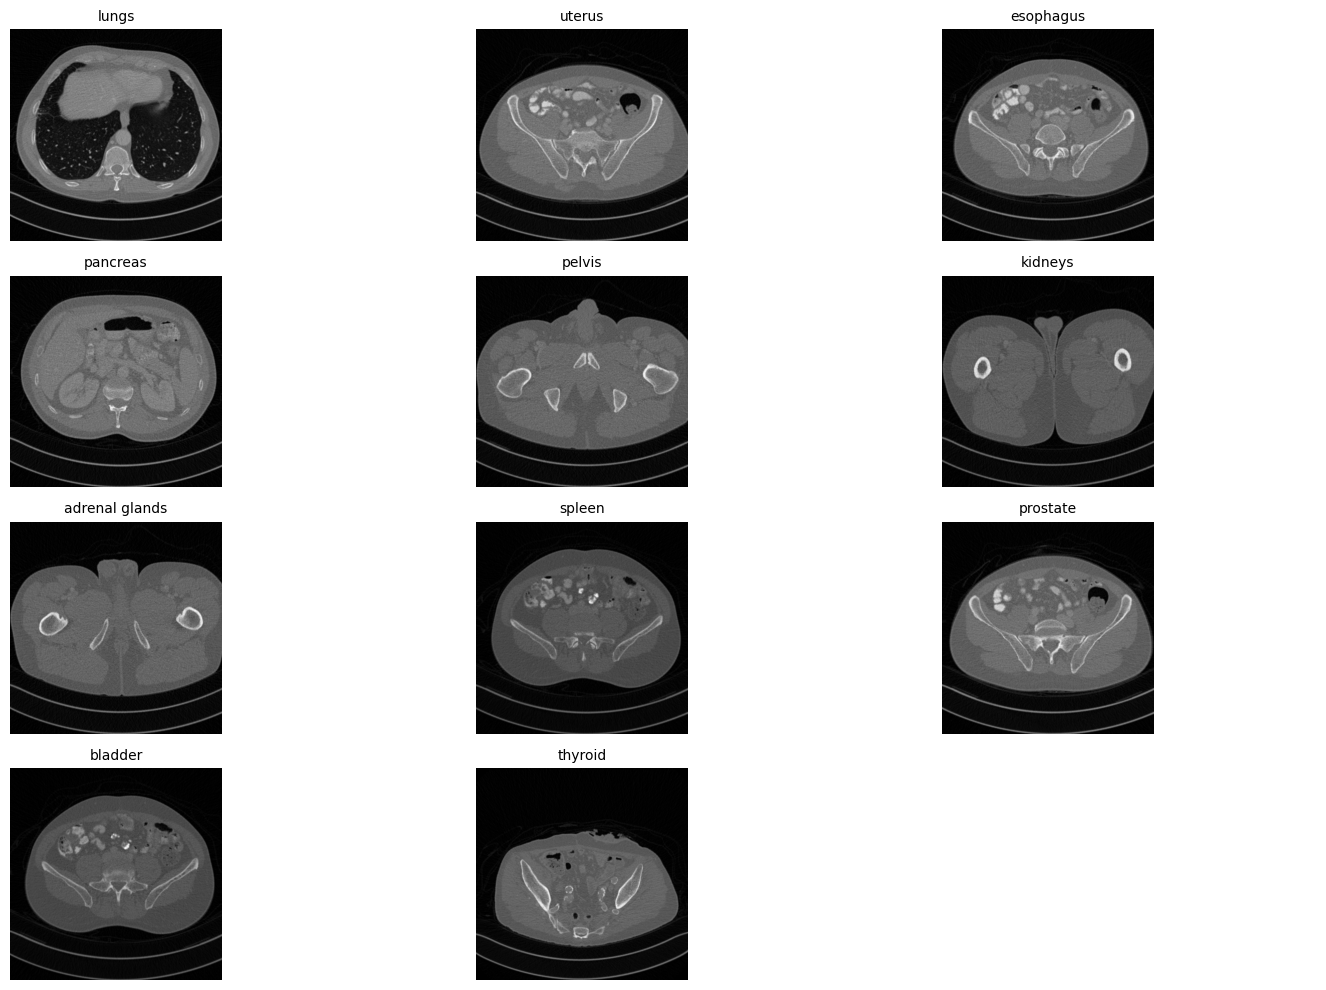

In [ ]:
import matplotlib.pyplot as plt
import math

# 분류된 장기 중 1개 이상 존재하는 것만 필터링
detected_organs = [organ for organ, indices in organ_indices.items() if len(indices) >= 1]

# 서브플롯 레이아웃 계산
num_organs = len(detected_organs)
rows = math.ceil(math.sqrt(num_organs))  # 제곱근 기반 행 계산
cols = math.ceil(num_organs / rows)      # 열 계산

# Figure 생성
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
if rows == 1 or cols == 1:
    axes = axes.reshape(-1)  # 1차원 배열로 변환

# 각 장기의 첫 번째 이미지 시각화
for ax, organ in zip(axes.flat, detected_organs):
    try:
        first_idx = organ_indices[organ][0]
        dicom_path = dicom_files[first_idx]
        dicom_img = load_dicom_image(dicom_path)
        
        ax.imshow(dicom_img, cmap='gray')
        ax.set_title(f"{organ}", fontsize=10)
        ax.axis('off')
    except IndexError:
        ax.axis('off')  # 오류 발생 시 축 숨기기
        continue

# 남은 빈 서브플롯 축 숨기기
for ax in axes.flat[num_organs:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### pubmedclip 사용하기

In [ ]:
!pip install torch torchvision transformers open_clip_torch

  Using cached open_clip_torch-2.31.0-py3-none-any.whl.metadata (31 kB)
  Using cached timm-1.0.15-py3-none-any.whl.metadata (52 kB)
Using cached open_clip_torch-2.31.0-py3-none-any.whl (1.5 MB)
Using cached timm-1.0.15-py3-none-any.whl (2.4 MB)


In [ ]:
import torch
from PIL import Image
from urllib.request import urlopen
from open_clip import create_model_from_pretrained, get_tokenizer

# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# 예제 이미지 및 텍스트
image_url = 'https://huggingface.co/microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224/resolve/main/example_data/biomed_image_classification_example_data/squamous_cell_carcinoma_histopathology.jpeg'
image = Image.open(urlopen(image_url))
texts = ['adenocarcinoma histopathology', 'squamous cell carcinoma histopathology']

# 이미지 및 텍스트 전처리
image_input = preprocess(image).unsqueeze(0).to(device)
text_input = tokenizer(texts).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = model(image_input, text_input)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(texts):
    print(f'{text}: {logits[0][i].item():.4f}')

adenocarcinoma histopathology: 0.0029
squamous cell carcinoma histopathology: 0.9971


In [ ]:
# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# 사용할 이미지
idx = 10
dicom_img = load_dicom_image(dicom_files[idx])
image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

# 장기 검색을 위한 텍스트
text_descriptions = [
    "brain",          # 뇌
    "lungs",          # 폐
    "liver",          # 간
    "stomach",        # 위
    "kidneys",        # 신장
    "pancreas",       # 췌장
    "spleen",         # 비장
    "heart",          # 심장
    "chest",          # 가슴 (흉부)
    "abdomen",        # 복부
    "pelvis",         # 골반
    "spine",          # 척추
    "ribs",           # 갈비뼈
    "bladder",        # 방광
    "prostate",       # 전립선 (남성)
    "uterus",         # 자궁 (여성)
    "adrenal glands", # 부신
    "thyroid",        # 갑상선
    "esophagus",      # 식도
    "intestines"      # 장
]
text_tokens = tokenizer(text_descriptions).to(device)

# 예측 수행
with torch.no_grad():
    image_features, text_features, logit_scale = model(image_tensor, text_tokens)
    logits = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

# 결과 출력
for i, text in enumerate(text_descriptions):
    print(f'{text}: {logits[0][i].item():.4f}')

brain: 0.0000
lungs: 0.0000
liver: 0.0000
stomach: 0.0000
kidneys: 0.0000
pancreas: 0.0000
spleen: 0.0000
heart: 0.0000
chest: 0.0000
abdomen: 0.0000
pelvis: 0.9843
spine: 0.0000
ribs: 0.0000
bladder: 0.0000
prostate: 0.0156
uterus: 0.0000
adrenal glands: 0.0000
thyroid: 0.0000
esophagus: 0.0000
intestines: 0.0000


Detected Organ: pelvis


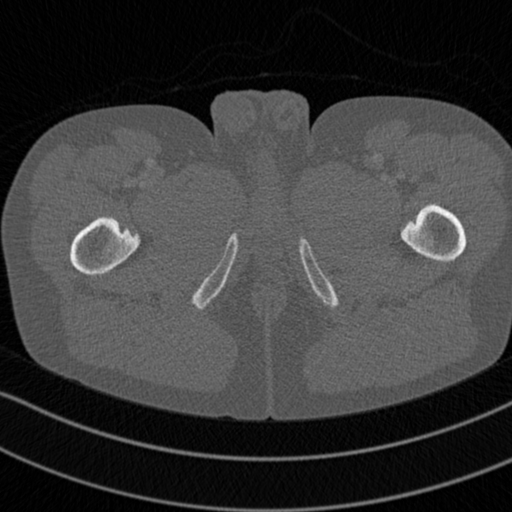

In [ ]:
# 코사인 유사도 계산
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarities = (image_features @ text_features.T).squeeze(0)

# 가장 유사한 장기 출력
best_match_idx = similarities.argmax().item()
print(f"Detected Organ: {text_descriptions[best_match_idx]}")

dicom_img.show()

In [ ]:
from collections import defaultdict

# 장기별 인덱스 저장을 위한 딕셔너리 초기화
organ_indices = defaultdict(list)  # 또는 {organ: [] for organ in text_descriptions}

for idx, dicom_path in enumerate(dicom_files):  # enumerate로 인덱스 추적
    dicom_img = load_dicom_image(dicom_path)
    image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        similarities = (image_features @ text_features.T).squeeze(0)

    best_match_idx = similarities.argmax().item()
    detected_organ = text_descriptions[best_match_idx]
    
    organ_indices[detected_organ].append(idx)  # 현재 파일의 인덱스 저장

# 결과 출력 (카운트 + 인덱스 리스트)
print("Organ counts in Mayo2016 dataset:")
for organ, indices in organ_indices.items():
    print(f"{organ}: {len(indices)}")

Organ counts in Mayo2016 dataset:
lungs: 1099
pelvis: 2531
pancreas: 269
prostate: 50
kidneys: 148
spleen: 1004
abdomen: 318
spine: 260
bladder: 37
liver: 58
chest: 112
thyroid: 41
intestines: 5
stomach: 2
adrenal glands: 2


In [ ]:
# 시각화 함수

def drawing(anomaly_organ, idx, organ_indices=organ_indices):
    if anomaly_organ in organ_indices:
        sample_idx = organ_indices[anomaly_organ][idx]
        sample_path = dicom_files[sample_idx]
        
        import matplotlib.pyplot as plt
        dicom_img = load_dicom_image(sample_path)
        plt.imshow(dicom_img, cmap='gray')
        plt.title(f"Detected: {anomaly_organ}")
        plt.show()
    else:
        print(f"No cases detected for {anomaly_organ}.")

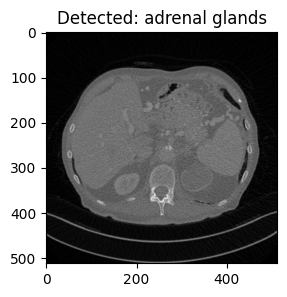

In [ ]:
anomaly_organ = "adrenal glands"
idx = 0

drawing(anomaly_organ, idx, organ_indices)

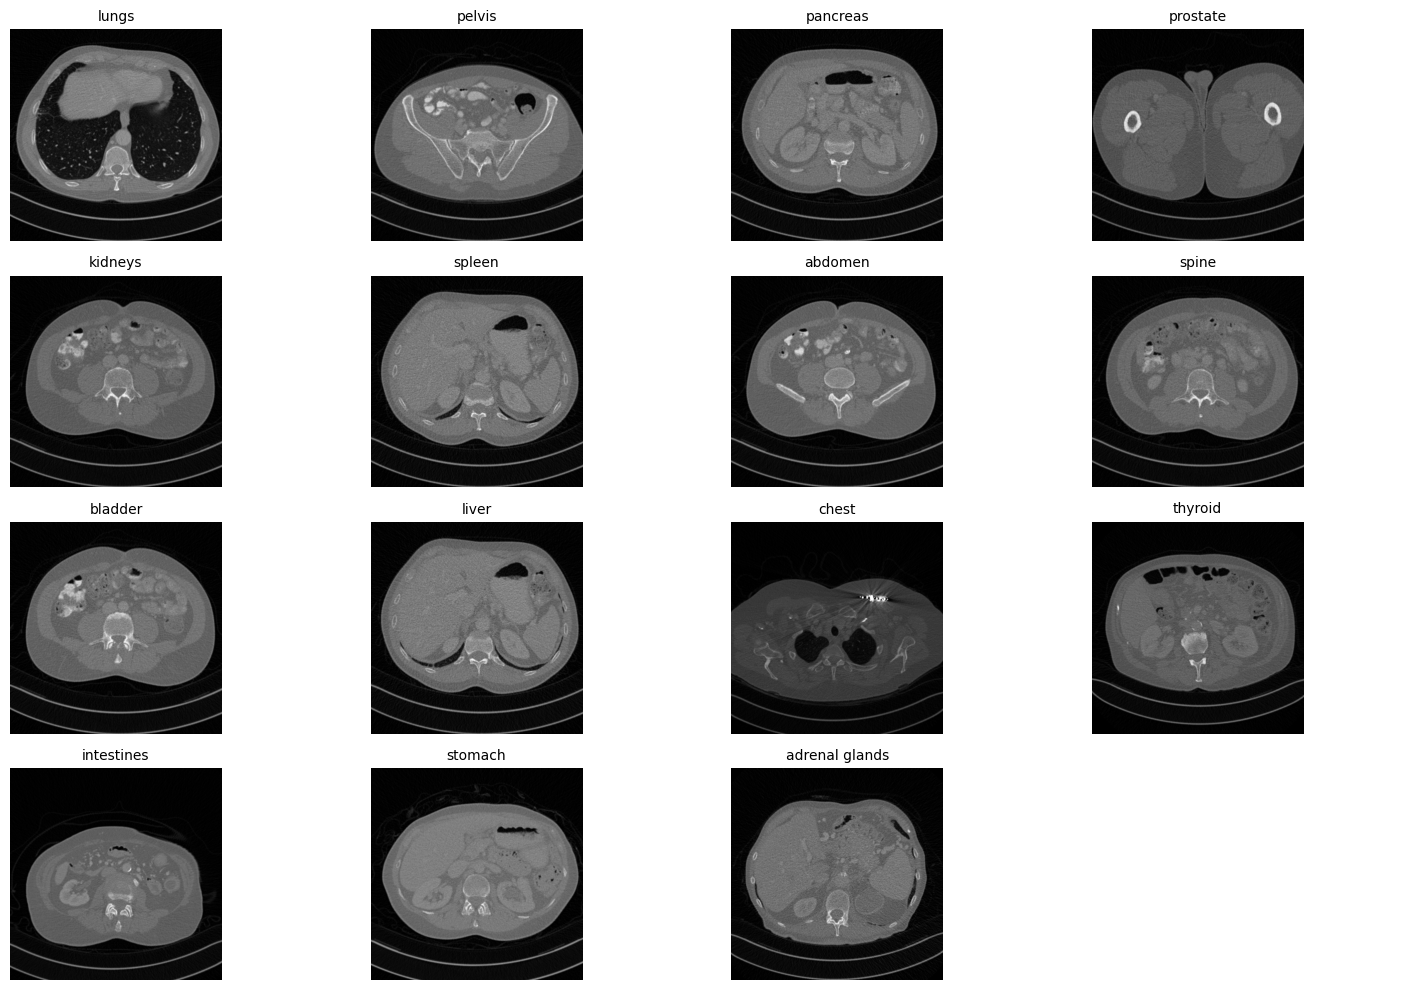

In [ ]:
import matplotlib.pyplot as plt
import math

# 분류된 장기 중 1개 이상 존재하는 것만 필터링
detected_organs = [organ for organ, indices in organ_indices.items() if len(indices) >= 1]

# 서브플롯 레이아웃 계산
num_organs = len(detected_organs)
rows = math.ceil(math.sqrt(num_organs))  # 제곱근 기반 행 계산
cols = math.ceil(num_organs / rows)      # 열 계산

# Figure 생성
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
if rows == 1 or cols == 1:
    axes = axes.reshape(-1)  # 1차원 배열로 변환

# 각 장기의 첫 번째 이미지 시각화
for ax, organ in zip(axes.flat, detected_organs):
    try:
        first_idx = organ_indices[organ][0]
        dicom_path = dicom_files[first_idx]
        dicom_img = load_dicom_image(dicom_path)
        
        ax.imshow(dicom_img, cmap='gray')
        ax.set_title(f"{organ}", fontsize=10)
        ax.axis('off')
    except IndexError:
        ax.axis('off')  # 오류 발생 시 축 숨기기
        continue

# 남은 빈 서브플롯 축 숨기기
for ax in axes.flat[num_organs:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## 2. 유사한걸로 클러스터링 하기

In [ ]:
import pandas as pd
from tqdm import tqdm  # 진행 상황 표시
from collections import defaultdict

# 저장할 리스트 초기화
dicom_locations = []
top10_organ_lists = []

# 모델 및 전처리기 로드
model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
model, preprocess = create_model_from_pretrained(model_name)
tokenizer = get_tokenizer(model_name)

# 모델을 평가 모드로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

CustomTextCLIP(
  (visual): TimmModel(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from tqdm import tqdm
from collections import defaultdict

In [ ]:
# 클러스터링 함수 정의
def cluster_ct_images(dicom_files, text_tokens, text_descriptions, num_clusters=3, method="PCA"):
    """CT 이미지를 PubMedCLIP으로 벡터화하고 클러스터링 수행"""
    
    image_vectors = []
    dicom_locations = []

    # tqdm을 사용하여 진행 상황 표시
    for dicom_path in tqdm(dicom_files, desc="Processing DICOM Files"):
        dicom_img = load_dicom_image(dicom_path)
        image_tensor = preprocess(dicom_img).unsqueeze(0).to(device)
        # PubMedCLIP 예측수행
        with torch.no_grad():
            image_features, text_features, logit_scale = model(image_tensor, text_tokens)
        # 코사인 유사도 계산
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarities = (image_features @ text_features.T).squeeze(0).cpu().numpy()
        # 벡터 저장
        image_vectors.append(similarities)
        dicom_locations.append(dicom_path)
    
    # NumPy 배열로 변환
    image_vectors = np.array(image_vectors)

    # 차원 축소 (PCA / t-SNE)
    if method == "PCA":
        reduced_vectors = PCA(n_components=2).fit_transform(image_vectors)
    elif method == "t-SNE":
        reduced_vectors = TSNE(n_components=2, perplexity=10, random_state=42).fit_transform(image_vectors)
    else:
        reduced_vectors = image_vectors  # Hierarchical Clustering은 차원 축소 없이 사용 가능

    # 클러스터링 수행
    if method in ["PCA", "t-SNE"]:
        clustering = KMeans(n_clusters=num_clusters, random_state=42).fit(reduced_vectors)
        labels = clustering.labels_
    elif method == "Hierarchical":
        clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(image_vectors)
        labels = clustering.labels_
 
 # 결과 시각화
    plt.figure(figsize=(8, 6))
    if method in ["PCA", "t-SNE"]:
        sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], hue=labels, palette="Set2", s=100)
        plt.xlabel(f"{method} Component 1")
        plt.ylabel(f"{method} Component 2")
        plt.title(f"CT Image Clustering using {method}")
    elif method == "Hierarchical":
        Z = linkage(image_vectors, method='ward')
        dendrogram(Z)
        plt.title("Hierarchical Clustering Dendrogram")

    plt.show()

    # DataFrame 생성
    df = pd.DataFrame({
        "DICOM Location": dicom_locations,
        "Cluster Label": labels
    })
    return df

Processing DICOM Files: 100%|██████████| 5936/5936 [06:44<00:00, 14.68it/s]


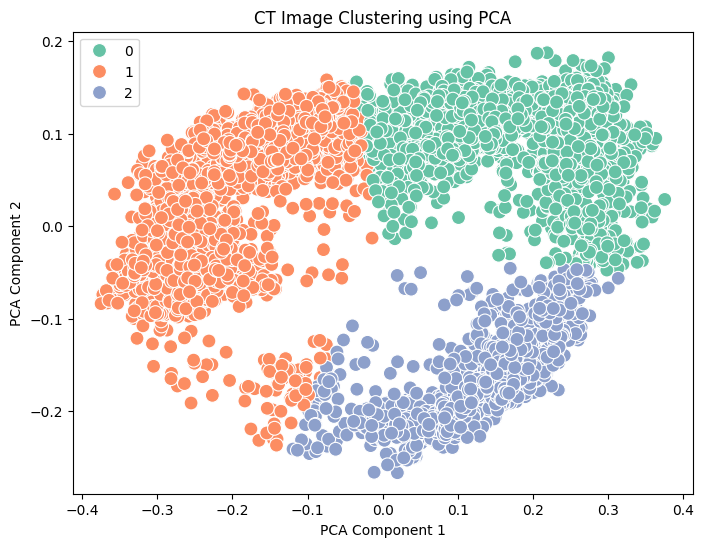

DICOM Location  Cluster Label
0  /root/mayo2016/L067/quarter_1mm/L067_QD_1_1.CT...              2
1  /root/mayo2016/L067/quarter_1mm/L067_QD_1_1.CT...              1
2  /root/mayo2016/L067/quarter_1mm/L067_QD_1_1.CT...              1
3  /root/mayo2016/L067/quarter_1mm/L067_QD_1_1.CT...              1
4  /root/mayo2016/L067/quarter_1mm/L067_QD_1_1.CT...              2

In [ ]:
# 실행 예제
num_clusters = 3
method = "PCA"  # "PCA", "t-SNE", "Hierarchical" 중 선택
text_descriptions = [
    "brain",          # 뇌
    "lungs",          # 폐
    "liver",          # 간
    "stomach",        # 위
    "kidneys",        # 신장
    "pancreas",       # 췌장
    "spleen",         # 비장
    "heart",          # 심장
    "chest",          # 가슴 (흉부)
    "abdomen",        # 복부
    "pelvis",         # 골반
    "spine",          # 척추
    "ribs",           # 갈비뼈
    "bladder",        # 방광
    "prostate",       # 전립선 (남성)
    "uterus",         # 자궁 (여성)
    "adrenal glands", # 부신
    "thyroid",        # 갑상선
    "esophagus",      # 식도
    "intestines"      # 장
]
text_tokens = tokenizer(text_descriptions).to(device)

df_clusters = cluster_ct_images(dicom_files, text_tokens, text_descriptions, num_clusters, method)
df_clusters.head()

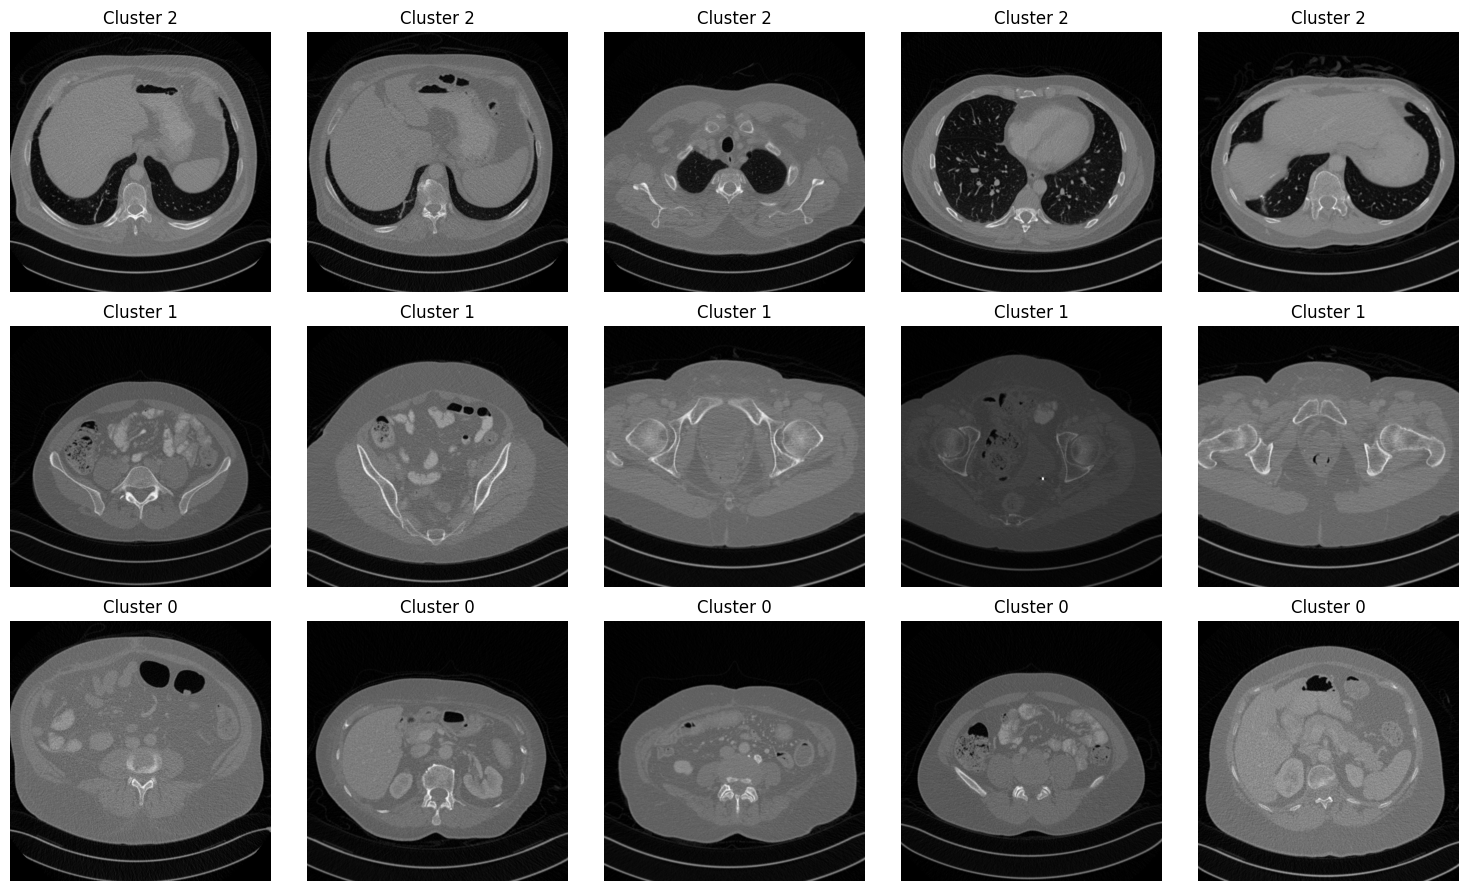

In [ ]:
import matplotlib.pyplot as plt
import random

# 클러스터 ID 리스트
cluster_ids = df_clusters["Cluster Label"].unique()

# 3행 5열의 서브플롯 생성
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, cluster_id in enumerate(cluster_ids[:3]):  # 최대 3개 클러스터만 시각화
    # 해당 클러스터의 샘플 5개 선택
    cluster_samples = df_clusters[df_clusters["Cluster Label"] == cluster_id]["DICOM Location"].sample(5, random_state=42)
    
    for j, dicom_path in enumerate(cluster_samples):
        img = load_dicom_image(dicom_path)  # DICOM 이미지를 로드하는 함수

        ax = axes[i, j]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Cluster {cluster_id}")
        ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
%cd /root/

/root


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
df_clusters.to_csv("/root/df_clusters.csv", index=False)

## 3. 욜로월드의 가이드 주기

# 일반 모델 학습

## 함수선언

In [12]:
L_list = glob.glob('/root/mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list = [path for path in L_list if 'L' in path]
L_list.sort()

data_label = ['quarter_1mm', 'full_1mm'] # 1mm 사용함

In [13]:
def normlize(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept

    # CT 값 클리핑 (일반적인 HU 범위: -1000~3000) <- 극단적인 값 제거를 위해
    img = np.clip(img, -1000, 3000) # 3000이 넘어가면 3000으로 바꿈

    # 정규화 (0~1 사이로)
    scaled_img = (img - img.min()) / (img.max() - img.min())
    
    # 제일 앞에 1차원 넣기
    img = np.expand_dims(scaled_img, axis=0)

    return img # 1x512x512

In [14]:
# Mayo 2016 데이터셋에서 DICOM 파일 찾기
base_folder = "/root/mayo2016"
img_type = "quarter_1mm"
dicom_files = []

# 모든 L0xx 폴더에서 DICOM 파일 수집
L_patients = L_list
for patient_id in L_patients:
    patient_folder = os.path.join(base_folder, patient_id, "quarter_1mm") # quarter_1mm
    if os.path.exists(patient_folder):
        patient_files = [os.path.join(patient_folder, f) 
                        for f in os.listdir(patient_folder) 
                        if f.endswith(".IMA")]
        dicom_files.extend(patient_files)

In [15]:
img = normlize(dicom_files[0])
img.shape, img.max(), img.min() # 0~1 사이어야 유리하다.

((1, 512, 512), 1.0, 0.0)

In [16]:
def extract_patches(img, patch_size=512, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55

추출된 패치 수: 1
각 패치의 크기: (1, 512, 512)


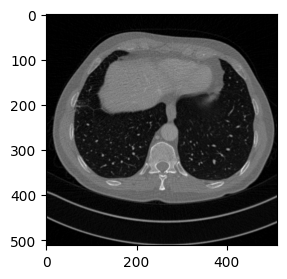

In [17]:
# 1x512x512 이미지에서 1x55x55 패치 추출
patch_size = 512
interval = 55
patches = extract_patches(img, patch_size, interval)

print(f"추출된 패치 수: {len(patches)}")
print(f"각 패치의 크기: {patches[0].shape}")

# 이미지 확인
plt.imshow(np.squeeze(patches[0]), cmap='gray')
plt.show()

In [18]:
from scipy.ndimage import rotate, zoom
import random

def augment_patches(X_patches, y_patches, p=0.5):
    
    X_augmented_patches, y_augmented_patches = [], []
    
    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [19]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=512, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=512, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  # X_augmented_patches = torch.from_numpy(X_augmented_patches).float()  # dtype=float 변환 추가
  # y_augmented_patches = torch.from_numpy(y_augmented_patches).float()
  return X_augmented_patches, y_augmented_patches

In [20]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=512, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=512, interval=55)
  # X_patches = torch.from_numpy(X_patches).float()  # dtype=float 변환 추가
  # y_patches = torch.from_numpy(y_patches).float()
  return X_patches, y_patches

In [21]:
i,j = 0,0
X_dir = sorted(glob.glob(f'/root/mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
y_dir = sorted(glob.glob(f'/root/mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]

X_patches, y_patches = patch_maker_W_aug(X_dir, y_dir)
print(X_patches.shape, y_patches.shape) # 3배 정도 늘어남

X_patches, y_patches = patch_maker_WO_aug(X_dir, y_dir)
print(X_patches.shape, y_patches.shape) # 1배 (기본)

(4, 1, 512, 512) (4, 1, 512, 512)
(1, 1, 512, 512) (1, 1, 512, 512)


## 데이터셋 정의

In [22]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list=L_list, data_label=data_label):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.data_label = data_label
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir
            y_dir_list += y_dir

        for X_dir, y_dir in tqdm(zip(X_dir_list, y_dir_list), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            for i in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[i]), torch.from_numpy(y_patches[i]) # torch로 넣어주자.
                self.image_pairs.append((X_patch, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'/root/mayo2016/{L}/{self.data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'/root/mayo2016/{L}/{self.data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)
        
        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = self.image_pairs[idx][0]
        y = self.image_pairs[idx][1]
        return X, y

In [23]:
# train_dataset = CustomDataset('train',patch_maker_W_aug,L_list[:])
# val_dataset = CustomDataset('val',patch_maker_WO_aug,L_list[:])
# test_dataset = CustomDataset('test',patch_maker_WO_aug,L_list[:])

In [24]:
# import os
# import shutil

# whole_folder = "/root/whole/"

# # 폴더가 존재하는지 확인
# if not os.path.exists(whole_folder):
#     os.makedirs(whole_folder)  # 폴더 생성
# else:
#     # 폴더 내부 파일 및 하위 폴더 삭제
#     for filename in os.listdir(whole_folder):
#         file_path = os.path.join(whole_folder, filename)
#         try:
#             if os.path.isfile(file_path) or os.path.islink(file_path):
#                 os.unlink(file_path)  # 파일 또는 심볼릭 링크 삭제
#             elif os.path.isdir(file_path):
#                 shutil.rmtree(file_path)  # 하위 폴더 삭제
#         except Exception as e:
#             print(f"파일 삭제 중 오류 발생: {file_path} - {e}")

# print(f"✅ '{whole_folder}' 폴더 준비 완료!")

In [25]:
whole_folder = "/root/whole/"

train_path = whole_folder + 'train_dataset.pt'
val_path = whole_folder + 'val_dataset.pt'
test_path = whole_folder + 'test_dataset.pt'

In [26]:
# # 데이터셋 저장
# torch.save(train_dataset, train_path)
# torch.save(val_dataset, val_path)
# torch.save(test_dataset, test_path)

In [27]:
# 데이터셋 불러오기
train_dataset = torch.load(train_path)
val_dataset = torch.load(val_path)
test_dataset = torch.load(test_path)

In [28]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

In [29]:
len(train_loader), len(val_loader), len(test_loader)

(11395, 951, 1190)

In [30]:
X_train, y_train = next(iter(train_loader))
X_train.shape, y_train.shape

(torch.Size([1, 1, 512, 512]), torch.Size([1, 1, 512, 512]))

In [31]:
X_val, y_val = next(iter(val_loader))
X_val.shape, y_val.shape

(torch.Size([1, 1, 512, 512]), torch.Size([1, 1, 512, 512]))

In [32]:
X_test, y_test = next(iter(test_loader))
X_test.shape, y_test.shape

(torch.Size([1, 1, 512, 512]), torch.Size([1, 1, 512, 512]))

In [33]:
def visualize_patches(X, y):
    fig, axes = plt.subplots(1, 2, figsize=(4, 8))  # 2행 16열로 설정

    # X 데이터 시각화
    axes[0].imshow(np.squeeze(X), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f"X", fontsize=10)
    
    # y 데이터 시각화
    axes[1].imshow(np.squeeze(y), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f"y", fontsize=10)
    
    plt.tight_layout()
    plt.show()

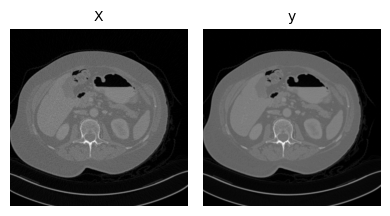

In [34]:
visualize_patches(X_train, y_train)

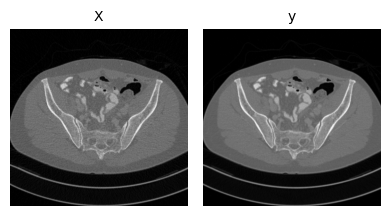

In [35]:
visualize_patches(X_val, y_val)

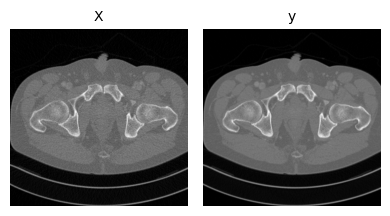

In [36]:
visualize_patches(X_test, y_test)

## 모델

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)
        
        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()


    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))
        
        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결
        
        return x

In [13]:
model = RedCNN().to(device)
model

RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
)

In [14]:
import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

<module 'utils.train_eval_util' from '/root/utils/train_eval_util.py'>

In [15]:
import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
import torch
from tqdm import tqdm

interval = 100

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            running_loss += loss.item() * X.size(0)

            if i % interval == interval-1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                total_loss += running_loss
                running_loss = 0.0
                tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)

In [17]:
print(f'X : {X_test.shape}\nX_hat : {model(X_test.to(device)).shape}\ny : {y_test.shape}')

NameError: name 'X_test' is not defined

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, y_train = next(iter(train_loader))

# 데이터를 모델과 동일한 디바이스로 이동
X_train = X_train.to(device)
y_train = y_train.to(device)  # 필요하면 y_train도 옮기기

# 모델도 동일한 디바이스로 이동
model = model.to(device)

X_hat = model(X_train)

print(X_train.shape, y_train.shape, X_hat.shape)

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])


In [ ]:
conv_layer = nn.Conv2d(1, 96, 5, 1, 0)
conv_layer(X_train.to('cpu')).shape

torch.Size([1, 96, 508, 508])

## 학습

In [ ]:
# import os
# import shutil

# patch_folder = "/root/base/whole"

# # 폴더가 존재하는지 확인
# if not os.path.exists(patch_folder):
#     os.makedirs(patch_folder)  # 폴더 생성
# else:
#     # 폴더 내부 파일 및 하위 폴더 삭제
#     for filename in os.listdir(patch_folder):
#         file_path = os.path.join(patch_folder, filename)
#         try:
#             if os.path.isfile(file_path) or os.path.islink(file_path):
#                 os.unlink(file_path)  # 파일 또는 심볼릭 링크 삭제
#             elif os.path.isdir(file_path):
#                 shutil.rmtree(file_path)  # 하위 폴더 삭제
#         except Exception as e:
#             print(f"파일 삭제 중 오류 발생: {file_path} - {e}")

# print(f"✅ '{patch_folder}' 폴더 준비 완료!")

✅ '/root/base/whole' 폴더 준비 완료!


In [47]:
model_name = '/root/base/whole/red_cnn_base'
epochs = 2 # 각 epoch마다 train(20분), valid(2분)이 소요된다.
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), f"{model_name}.pth")
        print('model is saving...')

Epoch 0 - Training:   1%|          | 101/11395 [00:09<17:18, 10.88it/s]

train loss : 0.0016021693660877646


Epoch 0 - Training:   2%|▏         | 201/11395 [00:18<17:17, 10.78it/s]

train loss : 0.0006568968578358181


Epoch 0 - Training:   3%|▎         | 301/11395 [00:27<17:09, 10.77it/s]

train loss : 0.0005137441639089956


Epoch 0 - Training:   4%|▎         | 401/11395 [00:37<17:05, 10.72it/s]

train loss : 0.0003600982442731038


Epoch 0 - Training:   4%|▍         | 501/11395 [00:46<16:56, 10.72it/s]

train loss : 0.0003966819273773581


Epoch 0 - Training:   5%|▌         | 601/11395 [00:55<16:51, 10.67it/s]

train loss : 0.0002885150536894798


Epoch 0 - Training:   6%|▌         | 701/11395 [01:05<16:44, 10.65it/s]

train loss : 0.00029082643588481007


Epoch 0 - Training:   7%|▋         | 801/11395 [01:14<16:36, 10.63it/s]

train loss : 0.0002506283693946898


Epoch 0 - Training:   8%|▊         | 901/11395 [01:23<16:28, 10.62it/s]

train loss : 0.00022171711068949662


Epoch 0 - Training:   9%|▉         | 1001/11395 [01:33<16:20, 10.61it/s]

train loss : 0.00032418316433904695


Epoch 0 - Training:  10%|▉         | 1101/11395 [01:42<16:11, 10.60it/s]

train loss : 0.00024650205989019014


Epoch 0 - Training:  11%|█         | 1201/11395 [01:52<16:01, 10.60it/s]

train loss : 0.0002152560518879909


Epoch 0 - Training:  11%|█▏        | 1301/11395 [02:01<16:04, 10.47it/s]

train loss : 0.00020776390432729384


Epoch 0 - Training:  12%|█▏        | 1401/11395 [02:10<15:44, 10.58it/s]

train loss : 0.00024176630988222313


Epoch 0 - Training:  13%|█▎        | 1501/11395 [02:20<15:36, 10.56it/s]

train loss : 0.00016619860820355826


Epoch 0 - Training:  14%|█▍        | 1601/11395 [02:29<15:28, 10.55it/s]

train loss : 0.0001886692949483404


Epoch 0 - Training:  15%|█▍        | 1701/11395 [02:39<15:15, 10.58it/s]

train loss : 0.00019632643878139788


Epoch 0 - Training:  16%|█▌        | 1801/11395 [02:48<15:03, 10.61it/s]

train loss : 0.0002060924598845304


Epoch 0 - Training:  17%|█▋        | 1901/11395 [02:58<14:57, 10.57it/s]

train loss : 0.00017795111245504813


Epoch 0 - Training:  18%|█▊        | 2001/11395 [03:07<14:45, 10.61it/s]

train loss : 0.0002229540159169119


Epoch 0 - Training:  18%|█▊        | 2101/11395 [03:16<14:37, 10.60it/s]

train loss : 0.00017911213984916685


Epoch 0 - Training:  19%|█▉        | 2201/11395 [03:26<14:26, 10.61it/s]

train loss : 0.00018988425203133374


Epoch 0 - Training:  20%|██        | 2301/11395 [03:35<14:17, 10.61it/s]

train loss : 0.00019366466167412


Epoch 0 - Training:  21%|██        | 2401/11395 [03:45<14:09, 10.59it/s]

train loss : 0.000246911872709461


Epoch 0 - Training:  22%|██▏       | 2501/11395 [03:54<13:57, 10.62it/s]

train loss : 0.00019209495352697558


Epoch 0 - Training:  23%|██▎       | 2601/11395 [04:03<13:49, 10.60it/s]

train loss : 0.00017039855469192845


Epoch 0 - Training:  24%|██▎       | 2701/11395 [04:13<13:43, 10.56it/s]

train loss : 0.00019168531569448532


Epoch 0 - Training:  25%|██▍       | 2801/11395 [04:22<13:34, 10.55it/s]

train loss : 0.0001644397842392209


Epoch 0 - Training:  25%|██▌       | 2901/11395 [04:32<13:24, 10.56it/s]

train loss : 0.00016857898164744257


Epoch 0 - Training:  26%|██▋       | 3001/11395 [04:41<13:15, 10.55it/s]

train loss : 0.00018035091197816656


Epoch 0 - Training:  27%|██▋       | 3101/11395 [04:51<13:05, 10.56it/s]

train loss : 0.0001792769369421876


Epoch 0 - Training:  28%|██▊       | 3201/11395 [05:00<12:57, 10.55it/s]

train loss : 0.00017038716356182704


Epoch 0 - Training:  29%|██▉       | 3301/11395 [05:09<12:46, 10.56it/s]

train loss : 0.00019363029696251033


Epoch 0 - Training:  30%|██▉       | 3401/11395 [05:19<12:36, 10.57it/s]

train loss : 0.0001751134776714025


Epoch 0 - Training:  31%|███       | 3501/11395 [05:28<12:28, 10.54it/s]

train loss : 0.00015936924879497382


Epoch 0 - Training:  32%|███▏      | 3601/11395 [05:38<12:17, 10.57it/s]

train loss : 0.0001914239082179847


Epoch 0 - Training:  32%|███▏      | 3701/11395 [05:47<12:07, 10.58it/s]

train loss : 0.0002323239358520368


Epoch 0 - Training:  33%|███▎      | 3801/11395 [05:57<12:07, 10.44it/s]

train loss : 0.00016426369958935538


Epoch 0 - Training:  34%|███▍      | 3901/11395 [06:06<11:47, 10.59it/s]

train loss : 0.00016048119898186996


Epoch 0 - Training:  35%|███▌      | 4001/11395 [06:15<11:39, 10.58it/s]

train loss : 0.0001598809643473942


Epoch 0 - Training:  36%|███▌      | 4101/11395 [06:25<11:38, 10.44it/s]

train loss : 0.00015184382442384958


Epoch 0 - Training:  37%|███▋      | 4201/11395 [06:34<11:20, 10.57it/s]

train loss : 0.0001703899709173129


Epoch 0 - Training:  38%|███▊      | 4301/11395 [06:44<11:11, 10.56it/s]

train loss : 0.00015359976194304181


Epoch 0 - Training:  39%|███▊      | 4401/11395 [06:53<11:15, 10.36it/s]

train loss : 0.00017410410448064794


Epoch 0 - Training:  39%|███▉      | 4501/11395 [07:03<10:52, 10.57it/s]

train loss : 0.00019603483066020998


Epoch 0 - Training:  40%|████      | 4601/11395 [07:12<10:43, 10.56it/s]

train loss : 0.00015517970387008974


Epoch 0 - Training:  41%|████▏     | 4701/11395 [07:21<10:33, 10.57it/s]

train loss : 0.00014190059340762673


Epoch 0 - Training:  42%|████▏     | 4801/11395 [07:31<10:23, 10.58it/s]

train loss : 0.00017402687128196704


Epoch 0 - Training:  43%|████▎     | 4901/11395 [07:40<10:13, 10.58it/s]

train loss : 0.00015112091849005084


Epoch 0 - Training:  44%|████▍     | 5001/11395 [07:50<10:05, 10.56it/s]

train loss : 0.0001568095595212071


Epoch 0 - Training:  45%|████▍     | 5101/11395 [07:59<09:54, 10.58it/s]

train loss : 0.00016960938522970538


Epoch 0 - Training:  46%|████▌     | 5201/11395 [08:09<09:43, 10.62it/s]

train loss : 0.00014852984226308762


Epoch 0 - Training:  47%|████▋     | 5301/11395 [08:18<09:34, 10.62it/s]

train loss : 0.00015931601607007906


Epoch 0 - Training:  47%|████▋     | 5401/11395 [08:27<09:25, 10.60it/s]

train loss : 0.00014650737863121323


Epoch 0 - Training:  48%|████▊     | 5501/11395 [08:37<09:15, 10.61it/s]

train loss : 0.0001499639392568497


Epoch 0 - Training:  49%|████▉     | 5601/11395 [08:46<09:05, 10.61it/s]

train loss : 0.00013731759165239055


Epoch 0 - Training:  50%|█████     | 5701/11395 [08:56<08:55, 10.63it/s]

train loss : 0.0001507532235336839


Epoch 0 - Training:  51%|█████     | 5801/11395 [09:05<08:48, 10.59it/s]

train loss : 0.0001657338804579922


Epoch 0 - Training:  52%|█████▏    | 5901/11395 [09:14<08:37, 10.61it/s]

train loss : 0.00015282538523024415


Epoch 0 - Training:  53%|█████▎    | 6001/11395 [09:24<08:31, 10.55it/s]

train loss : 0.00015130033181776526


Epoch 0 - Training:  54%|█████▎    | 6101/11395 [09:33<08:21, 10.56it/s]

train loss : 0.0001672906126259477


Epoch 0 - Training:  54%|█████▍    | 6201/11395 [09:43<08:11, 10.56it/s]

train loss : 0.00016888508456759156


Epoch 0 - Training:  55%|█████▌    | 6301/11395 [09:52<08:00, 10.61it/s]

train loss : 0.00014638681390351848


Epoch 0 - Training:  56%|█████▌    | 6401/11395 [10:02<07:52, 10.57it/s]

train loss : 0.00013804414971673395


Epoch 0 - Training:  57%|█████▋    | 6501/11395 [10:11<07:44, 10.54it/s]

train loss : 0.00015262233508110513


Epoch 0 - Training:  58%|█████▊    | 6601/11395 [10:20<07:33, 10.58it/s]

train loss : 0.0001911969763750676


Epoch 0 - Training:  59%|█████▉    | 6701/11395 [10:30<07:24, 10.56it/s]

train loss : 0.0001845377407516935


Epoch 0 - Training:  60%|█████▉    | 6801/11395 [10:39<07:14, 10.58it/s]

train loss : 0.00014940231420041528


Epoch 0 - Training:  61%|██████    | 6901/11395 [10:49<07:05, 10.57it/s]

train loss : 0.0001425695557918516


Epoch 0 - Training:  61%|██████▏   | 7001/11395 [10:58<06:56, 10.54it/s]

train loss : 0.00015872382442466915


Epoch 0 - Training:  62%|██████▏   | 7101/11395 [11:08<06:45, 10.59it/s]

train loss : 0.0001623478908004472


Epoch 0 - Training:  63%|██████▎   | 7201/11395 [11:17<06:37, 10.56it/s]

train loss : 0.00013353137343074194


Epoch 0 - Training:  64%|██████▍   | 7301/11395 [11:26<06:27, 10.56it/s]

train loss : 0.00015452352829015581


Epoch 0 - Training:  65%|██████▍   | 7401/11395 [11:36<06:17, 10.58it/s]

train loss : 0.00016032618932513288


Epoch 0 - Training:  66%|██████▌   | 7501/11395 [11:45<06:08, 10.57it/s]

train loss : 0.00017233736161870183


Epoch 0 - Training:  67%|██████▋   | 7601/11395 [11:55<06:00, 10.52it/s]

train loss : 0.0001567602723662276


Epoch 0 - Training:  68%|██████▊   | 7701/11395 [12:04<05:49, 10.58it/s]

train loss : 0.00014496147305180783


Epoch 0 - Training:  68%|██████▊   | 7801/11395 [12:14<05:40, 10.56it/s]

train loss : 0.0001438044792303117


Epoch 0 - Training:  69%|██████▉   | 7901/11395 [12:23<05:29, 10.60it/s]

train loss : 0.00013741754068178125


Epoch 0 - Training:  70%|███████   | 8001/11395 [12:32<05:21, 10.57it/s]

train loss : 0.00013966238280772815


Epoch 0 - Training:  71%|███████   | 8101/11395 [12:42<05:11, 10.58it/s]

train loss : 0.0001418305168772349


Epoch 0 - Training:  72%|███████▏  | 8201/11395 [12:51<05:02, 10.57it/s]

train loss : 0.00014667319166619563


Epoch 0 - Training:  73%|███████▎  | 8301/11395 [13:01<04:51, 10.60it/s]

train loss : 0.00015708271788753337


Epoch 0 - Training:  74%|███████▎  | 8401/11395 [13:10<04:43, 10.57it/s]

train loss : 0.00012848648500948912


Epoch 0 - Training:  75%|███████▍  | 8501/11395 [13:19<04:32, 10.62it/s]

train loss : 0.0001563240700852475


Epoch 0 - Training:  75%|███████▌  | 8601/11395 [13:29<04:23, 10.61it/s]

train loss : 0.00013959214025817347


Epoch 0 - Training:  76%|███████▋  | 8701/11395 [13:38<04:14, 10.60it/s]

train loss : 0.0001421164114435669


Epoch 0 - Training:  77%|███████▋  | 8801/11395 [13:48<04:04, 10.61it/s]

train loss : 0.00014349573950312334


Epoch 0 - Training:  78%|███████▊  | 8901/11395 [13:57<03:55, 10.59it/s]

train loss : 0.00014599995942262466


Epoch 0 - Training:  79%|███████▉  | 9001/11395 [14:06<03:45, 10.60it/s]

train loss : 0.00013060946410405449


Epoch 0 - Training:  80%|███████▉  | 9101/11395 [14:16<03:36, 10.61it/s]

train loss : 0.0001438340201275423


Epoch 0 - Training:  81%|████████  | 9201/11395 [14:25<03:26, 10.61it/s]

train loss : 0.00015184148418484255


Epoch 0 - Training:  82%|████████▏ | 9301/11395 [14:35<03:17, 10.62it/s]

train loss : 0.00013250042124127504


Epoch 0 - Training:  83%|████████▎ | 9401/11395 [14:44<03:08, 10.61it/s]

train loss : 0.00013651608936925185


Epoch 0 - Training:  83%|████████▎ | 9501/11395 [14:53<02:58, 10.60it/s]

train loss : 0.00014654216218332294


Epoch 0 - Training:  84%|████████▍ | 9601/11395 [15:03<02:49, 10.59it/s]

train loss : 0.00011622726626228541


Epoch 0 - Training:  85%|████████▌ | 9701/11395 [15:12<02:40, 10.57it/s]

train loss : 0.00014931085104763042


Epoch 0 - Training:  86%|████████▌ | 9801/11395 [15:22<02:30, 10.61it/s]

train loss : 0.00018648033099452732


Epoch 0 - Training:  87%|████████▋ | 9901/11395 [15:31<02:21, 10.59it/s]

train loss : 0.00013273672539071413


Epoch 0 - Training:  88%|████████▊ | 10001/11395 [15:41<02:11, 10.60it/s]

train loss : 0.00013771867448667764


Epoch 0 - Training:  89%|████████▊ | 10101/11395 [15:50<02:02, 10.60it/s]

train loss : 0.0001325312309563742


Epoch 0 - Training:  90%|████████▉ | 10201/11395 [15:59<01:52, 10.59it/s]

train loss : 0.00013614279123430606


Epoch 0 - Training:  90%|█████████ | 10301/11395 [16:09<01:43, 10.60it/s]

train loss : 0.0001458378430470475


Epoch 0 - Training:  91%|█████████▏| 10401/11395 [16:18<01:33, 10.60it/s]

train loss : 0.00017933839295437794


Epoch 0 - Training:  92%|█████████▏| 10501/11395 [16:28<01:24, 10.59it/s]

train loss : 0.00014323022314783885


Epoch 0 - Training:  93%|█████████▎| 10601/11395 [16:37<01:14, 10.60it/s]

train loss : 0.00012857025205448736


Epoch 0 - Training:  94%|█████████▍| 10701/11395 [16:46<01:05, 10.58it/s]

train loss : 0.00014790241712034913


Epoch 0 - Training:  95%|█████████▍| 10801/11395 [16:56<00:56, 10.59it/s]

train loss : 0.00015419853898492874


Epoch 0 - Training:  96%|█████████▌| 10901/11395 [17:05<00:46, 10.58it/s]

train loss : 0.00012666568447457392


Epoch 0 - Training:  97%|█████████▋| 11001/11395 [17:15<00:37, 10.61it/s]

train loss : 0.00015898366335022728


Epoch 0 - Training:  97%|█████████▋| 11101/11395 [17:24<00:27, 10.60it/s]

train loss : 0.00012013077779556625


Epoch 0 - Training:  98%|█████████▊| 11201/11395 [17:33<00:18, 10.61it/s]

train loss : 0.00013138178172084736


Epoch 0 - Training:  99%|█████████▉| 11301/11395 [17:43<00:08, 10.62it/s]

train loss : 0.0001441432465071557


Epoch 0 - Evaluating:  11%|█         | 104/951 [00:03<00:25, 32.72it/s]

train loss : 0.00021617428938043305


Epoch 0 - Evaluating:  21%|██▏       | 204/951 [00:06<00:22, 32.80it/s]

train loss : 0.00010705131491704378


Epoch 0 - Evaluating:  32%|███▏      | 304/951 [00:09<00:19, 32.97it/s]

train loss : 0.00021159197560336907


Epoch 0 - Evaluating:  42%|████▏     | 404/951 [00:12<00:16, 32.97it/s]

train loss : 0.0002565010943362722


Epoch 0 - Evaluating:  53%|█████▎    | 504/951 [00:15<00:13, 32.94it/s]

train loss : 0.00014814641515840777


Epoch 0 - Evaluating:  64%|██████▎   | 604/951 [00:18<00:10, 32.97it/s]

train loss : 0.00017202355575136609


Epoch 0 - Evaluating:  74%|███████▍  | 704/951 [00:21<00:07, 32.99it/s]

train loss : 0.00021321227512089536


Epoch 0 - Evaluating:  85%|████████▍ | 804/951 [00:24<00:04, 33.00it/s]

train loss : 0.00025002124391903635


Epoch 0 - Evaluating:  95%|█████████▌| 904/951 [00:27<00:01, 32.95it/s]

train loss : 0.00015859761835599785


Epoch 0 - Evaluating: 100%|██████████| 951/951 [00:29<00:00, 32.22it/s]

Epoch [1/2], Train Loss: 0.0002, Valid Loss: 0.0002
model is saving...



Epoch 1 - Training:   1%|          | 101/11395 [00:09<17:38, 10.67it/s]

train loss : 0.00014386068858584621


Epoch 1 - Training:   2%|▏         | 201/11395 [00:18<17:35, 10.60it/s]

train loss : 0.000143062686202029


Epoch 1 - Training:   3%|▎         | 301/11395 [00:28<17:26, 10.60it/s]

train loss : 0.00013803625784930773


Epoch 1 - Training:   4%|▎         | 401/11395 [00:37<17:16, 10.61it/s]

train loss : 0.00018407925450446782


Epoch 1 - Training:   4%|▍         | 501/11395 [00:47<17:09, 10.59it/s]

train loss : 0.00012912918737129075


Epoch 1 - Training:   5%|▌         | 601/11395 [00:56<16:58, 10.59it/s]

train loss : 0.00013187509444833267


Epoch 1 - Training:   6%|▌         | 701/11395 [01:05<16:47, 10.61it/s]

train loss : 0.00012614810046216007


Epoch 1 - Training:   7%|▋         | 801/11395 [01:15<16:34, 10.65it/s]

train loss : 0.00015610245274729094


Epoch 1 - Training:   8%|▊         | 901/11395 [01:24<16:25, 10.65it/s]

train loss : 0.0001302502365433611


Epoch 1 - Training:   9%|▉         | 1001/11395 [01:34<16:19, 10.61it/s]

train loss : 0.000143776154727675


Epoch 1 - Training:  10%|▉         | 1101/11395 [01:43<16:11, 10.59it/s]

train loss : 0.00014139664970571174


Epoch 1 - Training:  11%|█         | 1201/11395 [01:52<16:02, 10.59it/s]

train loss : 0.00013265365736515379


Epoch 1 - Training:  11%|█▏        | 1301/11395 [02:02<15:55, 10.56it/s]

train loss : 0.00012719201753498056


Epoch 1 - Training:  12%|█▏        | 1401/11395 [02:11<15:42, 10.60it/s]

train loss : 0.00013024391997532803


Epoch 1 - Training:  13%|█▎        | 1501/11395 [02:21<15:34, 10.59it/s]

train loss : 0.00014903625395163545


Epoch 1 - Training:  14%|█▍        | 1601/11395 [02:30<15:24, 10.59it/s]

train loss : 0.000135793609169923


Epoch 1 - Training:  15%|█▍        | 1701/11395 [02:39<15:16, 10.58it/s]

train loss : 0.0001266978320381895


Epoch 1 - Training:  16%|█▌        | 1801/11395 [02:49<15:13, 10.51it/s]

train loss : 0.00012793105677701532


Epoch 1 - Training:  17%|█▋        | 1901/11395 [02:58<14:56, 10.59it/s]

train loss : 0.00012508065199654084


Epoch 1 - Training:  18%|█▊        | 2001/11395 [03:08<14:46, 10.59it/s]

train loss : 0.00012848673490225337


Epoch 1 - Training:  18%|█▊        | 2101/11395 [03:17<14:39, 10.57it/s]

train loss : 0.00013674568092028494


Epoch 1 - Training:  19%|█▉        | 2201/11395 [03:27<14:28, 10.59it/s]

train loss : 0.00012809659197955626


Epoch 1 - Training:  20%|██        | 2301/11395 [03:36<14:19, 10.58it/s]

train loss : 0.00012956389109604062


Epoch 1 - Training:  21%|██        | 2401/11395 [03:45<14:15, 10.52it/s]

train loss : 0.00013465342526615133


Epoch 1 - Training:  22%|██▏       | 2501/11395 [03:55<14:00, 10.58it/s]

train loss : 0.00012684544522926445


Epoch 1 - Training:  23%|██▎       | 2601/11395 [04:04<13:50, 10.59it/s]

train loss : 0.00014694659626911743


Epoch 1 - Training:  24%|██▎       | 2701/11395 [04:14<13:41, 10.59it/s]

train loss : 0.0001478615003361483


Epoch 1 - Training:  25%|██▍       | 2801/11395 [04:23<13:32, 10.58it/s]

train loss : 0.00013865894281479995


Epoch 1 - Training:  25%|██▌       | 2901/11395 [04:32<13:22, 10.59it/s]

train loss : 0.0001295764360111207


Epoch 1 - Training:  26%|██▋       | 3001/11395 [04:42<13:13, 10.58it/s]

train loss : 0.00013611173304525437


Epoch 1 - Training:  27%|██▋       | 3101/11395 [04:51<13:01, 10.62it/s]

train loss : 0.0001411389510758454


Epoch 1 - Training:  28%|██▊       | 3201/11395 [05:01<12:54, 10.58it/s]

train loss : 0.00012478732242016122


Epoch 1 - Training:  29%|██▉       | 3301/11395 [05:10<12:45, 10.58it/s]

train loss : 0.00014532052366121207


Epoch 1 - Training:  30%|██▉       | 3401/11395 [05:20<12:34, 10.59it/s]

train loss : 0.00013846388112142449


Epoch 1 - Training:  31%|███       | 3501/11395 [05:29<12:25, 10.58it/s]

train loss : 0.0001334316376960487


Epoch 1 - Training:  32%|███▏      | 3601/11395 [05:38<12:15, 10.59it/s]

train loss : 0.00012592326653248164


Epoch 1 - Training:  32%|███▏      | 3701/11395 [05:48<12:06, 10.59it/s]

train loss : 0.00012521692435257136


Epoch 1 - Training:  33%|███▎      | 3801/11395 [05:57<11:56, 10.60it/s]

train loss : 0.00012517086972366087


Epoch 1 - Training:  34%|███▍      | 3901/11395 [06:07<11:46, 10.60it/s]

train loss : 0.00012785728307790123


Epoch 1 - Training:  35%|███▌      | 4001/11395 [06:16<11:38, 10.59it/s]

train loss : 0.00012827067219404854


Epoch 1 - Training:  36%|███▌      | 4101/11395 [06:25<11:28, 10.60it/s]

train loss : 0.0001297400266957993


Epoch 1 - Training:  37%|███▋      | 4201/11395 [06:35<11:19, 10.58it/s]

train loss : 0.00012076647031790344


Epoch 1 - Training:  38%|███▊      | 4301/11395 [06:44<11:09, 10.59it/s]

train loss : 0.0001280243610017351


Epoch 1 - Training:  39%|███▊      | 4401/11395 [06:54<10:59, 10.60it/s]

train loss : 0.00015804915317858104


Epoch 1 - Training:  39%|███▉      | 4501/11395 [07:03<10:51, 10.58it/s]

train loss : 0.0001252269299402542


Epoch 1 - Training:  40%|████      | 4601/11395 [07:12<10:39, 10.63it/s]

train loss : 0.00011678795101033757


Epoch 1 - Training:  41%|████▏     | 4701/11395 [07:22<10:29, 10.64it/s]

train loss : 0.00012750719302857762


Epoch 1 - Training:  42%|████▏     | 4801/11395 [07:31<10:21, 10.62it/s]

train loss : 0.00012335719791735754


Epoch 1 - Training:  43%|████▎     | 4901/11395 [07:41<10:10, 10.64it/s]

train loss : 0.00013401990436250343


Epoch 1 - Training:  44%|████▍     | 5001/11395 [07:50<10:00, 10.64it/s]

train loss : 0.00012112008669646457


Epoch 1 - Training:  45%|████▍     | 5101/11395 [07:59<09:52, 10.63it/s]

train loss : 0.00013019911282754037


Epoch 1 - Training:  46%|████▌     | 5201/11395 [08:09<09:42, 10.64it/s]

train loss : 0.000143050485967251


Epoch 1 - Training:  47%|████▋     | 5301/11395 [08:18<09:32, 10.64it/s]

train loss : 0.00014221276785974623


Epoch 1 - Training:  47%|████▋     | 5401/11395 [08:27<09:23, 10.64it/s]

train loss : 0.00013902157650591107


Epoch 1 - Training:  48%|████▊     | 5501/11395 [08:37<09:13, 10.65it/s]

train loss : 0.0001168040123047831


Epoch 1 - Training:  49%|████▉     | 5601/11395 [08:46<09:06, 10.60it/s]

train loss : 0.0001332099991486757


Epoch 1 - Training:  50%|█████     | 5701/11395 [08:56<08:57, 10.60it/s]

train loss : 0.00014130277313597616


Epoch 1 - Training:  51%|█████     | 5801/11395 [09:05<08:48, 10.59it/s]

train loss : 0.00012072696765244473


Epoch 1 - Training:  52%|█████▏    | 5901/11395 [09:14<08:38, 10.60it/s]

train loss : 0.00012815024696465115


Epoch 1 - Training:  53%|█████▎    | 6001/11395 [09:24<08:30, 10.57it/s]

train loss : 0.00011607988855757867


Epoch 1 - Training:  54%|█████▎    | 6101/11395 [09:33<08:18, 10.62it/s]

train loss : 0.00014416416344829487


Epoch 1 - Training:  54%|█████▍    | 6201/11395 [09:43<08:10, 10.59it/s]

train loss : 0.0001045678682930884


Epoch 1 - Training:  55%|█████▌    | 6301/11395 [09:52<08:00, 10.59it/s]

train loss : 0.00011204331885892316


Epoch 1 - Training:  56%|█████▌    | 6401/11395 [10:02<07:49, 10.65it/s]

train loss : 0.00012689469582255697


Epoch 1 - Training:  57%|█████▋    | 6501/11395 [10:11<07:39, 10.65it/s]

train loss : 0.00014261132906540297


Epoch 1 - Training:  58%|█████▊    | 6601/11395 [10:20<07:31, 10.63it/s]

train loss : 0.00014410720963496714


Epoch 1 - Training:  59%|█████▉    | 6701/11395 [10:30<07:22, 10.62it/s]

train loss : 0.0001279248999344418


Epoch 1 - Training:  60%|█████▉    | 6801/11395 [10:39<07:13, 10.60it/s]

train loss : 0.00013882854338589823


Epoch 1 - Training:  61%|██████    | 6901/11395 [10:48<07:02, 10.63it/s]

train loss : 0.00012165722810095759


Epoch 1 - Training:  61%|██████▏   | 7001/11395 [10:58<06:53, 10.64it/s]

train loss : 0.0001164477237398387


Epoch 1 - Training:  62%|██████▏   | 7101/11395 [11:07<06:45, 10.59it/s]

train loss : 0.0001378469626433798


Epoch 1 - Training:  63%|██████▎   | 7201/11395 [11:17<06:35, 10.60it/s]

train loss : 0.00011830356914288131


Epoch 1 - Training:  64%|██████▍   | 7301/11395 [11:26<06:26, 10.58it/s]

train loss : 0.000133839084628562


Epoch 1 - Training:  65%|██████▍   | 7401/11395 [11:35<06:17, 10.58it/s]

train loss : 0.00012330550023762044


Epoch 1 - Training:  66%|██████▌   | 7501/11395 [11:45<06:07, 10.58it/s]

train loss : 0.0001433719698252389


Epoch 1 - Training:  67%|██████▋   | 7601/11395 [11:54<05:58, 10.60it/s]

train loss : 0.00011683198354148772


Epoch 1 - Training:  68%|██████▊   | 7701/11395 [12:04<05:49, 10.58it/s]

train loss : 0.0001253516804717947


Epoch 1 - Training:  68%|██████▊   | 7801/11395 [12:13<05:39, 10.59it/s]

train loss : 0.00014284186481745565


Epoch 1 - Training:  69%|██████▉   | 7901/11395 [12:22<05:29, 10.59it/s]

train loss : 0.00015123743538424605


Epoch 1 - Training:  70%|███████   | 8001/11395 [12:32<05:20, 10.60it/s]

train loss : 0.00014055728799576174


Epoch 1 - Training:  71%|███████   | 8101/11395 [12:41<05:12, 10.53it/s]

train loss : 0.00013434269592835335


Epoch 1 - Training:  72%|███████▏  | 8201/11395 [12:51<05:01, 10.60it/s]

train loss : 0.00013930307981354417


Epoch 1 - Training:  73%|███████▎  | 8301/11395 [13:00<04:52, 10.60it/s]

train loss : 0.00013397940772847506


Epoch 1 - Training:  74%|███████▎  | 8401/11395 [13:10<04:44, 10.51it/s]

train loss : 0.00011516032816871302


Epoch 1 - Training:  75%|███████▍  | 8501/11395 [13:19<04:33, 10.60it/s]

train loss : 0.00012815646212402498


Epoch 1 - Training:  75%|███████▌  | 8601/11395 [13:28<04:23, 10.59it/s]

train loss : 0.0001426687253479031


Epoch 1 - Training:  76%|███████▋  | 8701/11395 [13:38<04:14, 10.58it/s]

train loss : 0.00012910475641547236


Epoch 1 - Training:  77%|███████▋  | 8801/11395 [13:47<04:04, 10.59it/s]

train loss : 0.00011488573876704322


Epoch 1 - Training:  78%|███████▊  | 8901/11395 [13:57<03:54, 10.64it/s]

train loss : 0.00013210326866101241


Epoch 1 - Training:  79%|███████▉  | 9001/11395 [14:06<03:45, 10.62it/s]

train loss : 0.00012077640281859204


Epoch 1 - Training:  80%|███████▉  | 9101/11395 [14:15<03:35, 10.64it/s]

train loss : 0.00013014902993745635


Epoch 1 - Training:  81%|████████  | 9201/11395 [14:25<03:26, 10.63it/s]

train loss : 0.0001337013745433069


Epoch 1 - Training:  82%|████████▏ | 9301/11395 [14:34<03:16, 10.64it/s]

train loss : 0.00013504763221135362


Epoch 1 - Training:  83%|████████▎ | 9401/11395 [14:44<03:07, 10.64it/s]

train loss : 0.00013214629185313243


Epoch 1 - Training:  83%|████████▎ | 9501/11395 [14:53<02:58, 10.64it/s]

train loss : 0.00012304340827540728


Epoch 1 - Training:  84%|████████▍ | 9601/11395 [15:02<02:48, 10.63it/s]

train loss : 0.000125631010523648


Epoch 1 - Training:  85%|████████▌ | 9701/11395 [15:12<02:39, 10.63it/s]

train loss : 0.00013662880675838096


Epoch 1 - Training:  86%|████████▌ | 9801/11395 [15:21<02:29, 10.64it/s]

train loss : 0.00011565450215130113


Epoch 1 - Training:  87%|████████▋ | 9901/11395 [15:30<02:20, 10.63it/s]

train loss : 0.00012714020325802267


Epoch 1 - Training:  88%|████████▊ | 10001/11395 [15:40<02:11, 10.58it/s]

train loss : 0.00011959026302065468


Epoch 1 - Training:  89%|████████▊ | 10101/11395 [15:49<02:02, 10.57it/s]

train loss : 0.00013147101357390055


Epoch 1 - Training:  90%|████████▉ | 10201/11395 [15:59<01:52, 10.57it/s]

train loss : 0.00012834804250815067


Epoch 1 - Training:  90%|█████████ | 10301/11395 [16:08<01:43, 10.57it/s]

train loss : 0.00012150544946052832


Epoch 1 - Training:  91%|█████████▏| 10401/11395 [16:18<01:33, 10.57it/s]

train loss : 0.00012118529297367786


Epoch 1 - Training:  92%|█████████▏| 10501/11395 [16:27<01:24, 10.58it/s]

train loss : 0.00012541106512799162


Epoch 1 - Training:  93%|█████████▎| 10601/11395 [16:36<01:15, 10.58it/s]

train loss : 0.00011951936450714129


Epoch 1 - Training:  94%|█████████▍| 10701/11395 [16:46<01:05, 10.58it/s]

train loss : 0.00012649968157347758


Epoch 1 - Training:  95%|█████████▍| 10801/11395 [16:55<00:56, 10.57it/s]

train loss : 0.00012520192529336783


Epoch 1 - Training:  96%|█████████▌| 10901/11395 [17:05<00:46, 10.57it/s]

train loss : 0.00012294909700358403


Epoch 1 - Training:  97%|█████████▋| 11001/11395 [17:14<00:37, 10.59it/s]

train loss : 0.00012956262960869935


Epoch 1 - Training:  97%|█████████▋| 11101/11395 [17:23<00:27, 10.59it/s]

train loss : 0.00011623250511547668


Epoch 1 - Training:  98%|█████████▊| 11201/11395 [17:33<00:18, 10.59it/s]

train loss : 0.00011985449758867616


Epoch 1 - Training:  99%|█████████▉| 11301/11395 [17:42<00:08, 10.59it/s]

train loss : 0.000126697763807897


Epoch 1 - Evaluating:  11%|█         | 103/951 [00:03<00:26, 32.50it/s]

train loss : 0.0001214632176925079


Epoch 1 - Evaluating:  21%|██▏       | 203/951 [00:06<00:23, 32.48it/s]

train loss : 5.0591177932801655e-05


Epoch 1 - Evaluating:  32%|███▏      | 303/951 [00:09<00:19, 32.60it/s]

train loss : 0.00013904914569138783


Epoch 1 - Evaluating:  42%|████▏     | 403/951 [00:12<00:16, 32.66it/s]

train loss : 0.0001700143321068026


Epoch 1 - Evaluating:  53%|█████▎    | 503/951 [00:15<00:13, 32.62it/s]

train loss : 0.00010536362548009492


Epoch 1 - Evaluating:  63%|██████▎   | 603/951 [00:18<00:10, 32.72it/s]

train loss : 0.00012918943772092462


Epoch 1 - Evaluating:  74%|███████▍  | 703/951 [00:21<00:07, 32.63it/s]

train loss : 0.00010731679685704876


Epoch 1 - Evaluating:  84%|████████▍ | 803/951 [00:24<00:04, 32.47it/s]

train loss : 0.00012889035569969566


Epoch 1 - Evaluating:  95%|█████████▍| 903/951 [00:27<00:01, 32.55it/s]

train loss : 7.864410836191382e-05


Epoch 1 - Evaluating: 100%|██████████| 951/951 [00:29<00:00, 31.85it/s]

Epoch [2/2], Train Loss: 0.0001, Valid Loss: 0.0001
model is saving...


In [48]:
%cd /root/base/whole

/root/base/whole


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [49]:
!pwd

/root/base/whole


In [50]:
import pickle

data_to_save = {
    'train_loss_per_iter': train_loss_per_iter,
    'val_loss_per_iter': val_loss_per_iter,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch
}

for filename, data in data_to_save.items():
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [51]:
import pickle

filenames = [
    'train_loss_per_iter.pkl',
    'val_loss_per_iter.pkl',
    'train_loss_per_epoch.pkl',
    'val_loss_per_epoch.pkl'
]

variables = [
    'train_loss_per_iter',
    'val_loss_per_iter',
    'train_loss_per_epoch',
    'val_loss_per_epoch'
]

data_to_load = dict(zip(filenames, variables))

for filename, variable_name in data_to_load.items():
    with open(filename, 'rb') as f:
        globals()[variable_name] = pickle.load(f)

In [52]:
train_flatten, val_flatten = [item for sublist in train_loss_per_iter for item in sublist], [item for sublist in val_loss_per_iter for item in sublist]

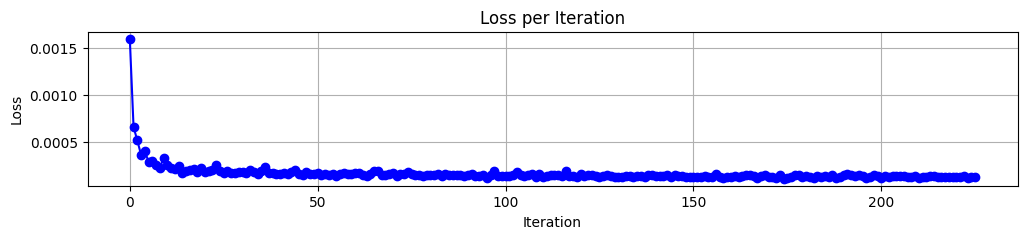

In [53]:
plt.figure(figsize=(12, 2))

# 반복 단위 손실 그래프
plt.plot(train_flatten, label='Train (per iter)', linestyle='-', marker='o', color='blue')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

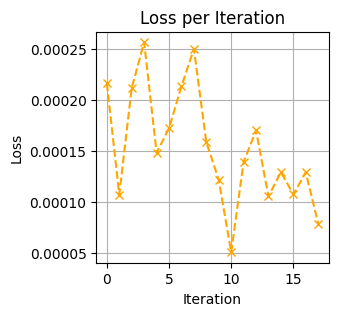

In [54]:
plt.plot(val_flatten, label='Validation (per iter)', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

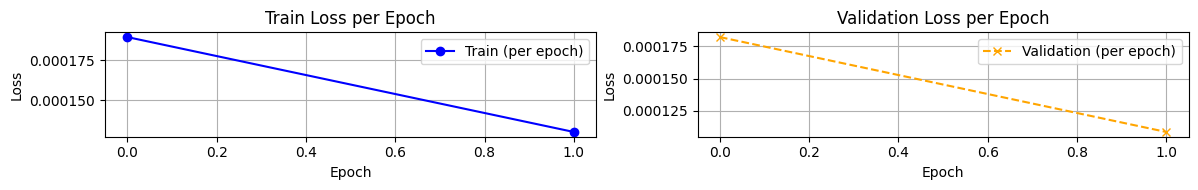

In [55]:
# 1행 2열 레이아웃 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 2))  # 그래프 크기 조정

# Train loss per epoch 그래프
axes[0].plot(train_loss_per_epoch, label='Train (per epoch)', linestyle='-', marker='o', color='blue')
axes[0].set_title("Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# Validation loss per epoch 그래프
axes[1].plot(val_loss_per_epoch, label='Validation (per epoch)', linestyle='--', marker='x', color='orange')
axes[1].set_title("Validation Loss per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

## 평가

In [57]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 전체 데이터에 대해

In [58]:
criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('/root/base/whole/red_cnn_base.pth'))

<All keys matched successfully>

In [59]:
test_path = '/root/whole/test_dataset.pt'
test_dataset = torch.load(test_path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

1190

In [60]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:   9%|▊         | 103/1190 [00:03<00:32, 33.40it/s]

train loss : 0.0001218563685688423


Evaluating:  17%|█▋        | 203/1190 [00:06<00:29, 33.01it/s]

train loss : 5.0014760290650884e-05


Evaluating:  25%|██▌       | 303/1190 [00:09<00:26, 33.15it/s]

train loss : 7.574455754365772e-05


Evaluating:  34%|███▍      | 403/1190 [00:12<00:23, 33.07it/s]

train loss : 0.00016096537859993987


Evaluating:  42%|████▏     | 503/1190 [00:15<00:21, 32.71it/s]

train loss : 0.0001586370601944509


Evaluating:  51%|█████     | 603/1190 [00:18<00:17, 32.97it/s]

train loss : 7.651124942640309e-05


Evaluating:  59%|█████▉    | 703/1190 [00:21<00:14, 33.00it/s]

train loss : 8.171491899702232e-05


Evaluating:  67%|██████▋   | 803/1190 [00:24<00:11, 32.98it/s]

train loss : 8.905186092306394e-05


Evaluating:  76%|███████▌  | 903/1190 [00:27<00:08, 32.90it/s]

train loss : 9.56631153167109e-05


Evaluating:  84%|████████▍ | 1003/1190 [00:30<00:05, 32.87it/s]

train loss : 7.476128506823442e-05


Evaluating:  93%|█████████▎| 1103/1190 [00:33<00:02, 32.84it/s]

train loss : 7.146383493818576e-05


Evaluating: 100%|██████████| 1190/1190 [00:36<00:00, 32.52it/s]


In [61]:
# def reconstruct_image(prediction, num_patches_per_row=9, patch_size=55):
#     # prediction: (81, 1, 55, 55) 크기의 torch 텐서
#     num_patches = prediction.shape[0]  # 81개의 패치
#     assert prediction.shape == (81, 1, 55, 55) # "패치의 크기가 올바르지 않습니다."
    
#     # 최종적으로 1x495x495 크기의 이미지를 만들기 위한 초기화
#     final_image = torch.zeros(1, num_patches_per_row * patch_size, num_patches_per_row * patch_size)
    
#     # 9x9 배열로 패치 붙이기
#     for i in range(num_patches):
#         row = i // num_patches_per_row  # 현재 패치의 행 번호
#         col = i % num_patches_per_row   # 현재 패치의 열 번호
        
#         # 패치를 해당 위치에 붙이기
#         final_image[:, 
#                     row * patch_size:(row + 1) * patch_size, 
#                     col * patch_size:(col + 1) * patch_size] = prediction[i, 0]

#     return final_image

In [62]:
# def extract_patches(img, patch_size=55, interval=55):
#     patches = []
#     _, height, width = img.shape
#     for y in range(0, height - patch_size + 1, interval):
#         for x in range(0, width - patch_size + 1, interval):
#             patch = img[:, y:y + patch_size, x:x + patch_size]
#             patches.append(patch)
#     patches = torch.stack(patches)  # 리스트를 텐서로 변환
#     return patches  # 반환 형태는 patch 수 x 1 x 55 x 55

In [63]:
def rescale(normalized_img, original_min=-1000, original_max=3000):
    """
    정규화된 이미지를 원래 HU 범위로 복원하는 함수

    :param normalized_img: 정규화된 이미지 (0~1)
    :param original_min: 원본 HU 최소값
    :param original_max: 원본 HU 최대값
    :return: 원래 HU 값으로 복원된 이미지
    """
    restored_img = normalized_img * (original_max - original_min) + original_min
    return restored_img

In [64]:
def trans_img(X):
    return rescale(np.squeeze(X.cpu()))

In [65]:
def save_img(X_test, X_hat, y_test, s):
    # X_test 저장
    numpy_X_test = trans_img(X_test).numpy()
    np.save(f'X_test_image{s}.npy', numpy_X_test)
    
    # X_hat 저장
    numpy_X_hat = trans_img(X_hat).numpy()
    np.save(f'X_hat_image{s}.npy', numpy_X_hat)
    
    # y_test 저장
    numpy_y_test = trans_img(y_test).numpy()
    np.save(f'y_test_image{s}.npy', numpy_y_test)

In [66]:
# trans_img(X_test).shape

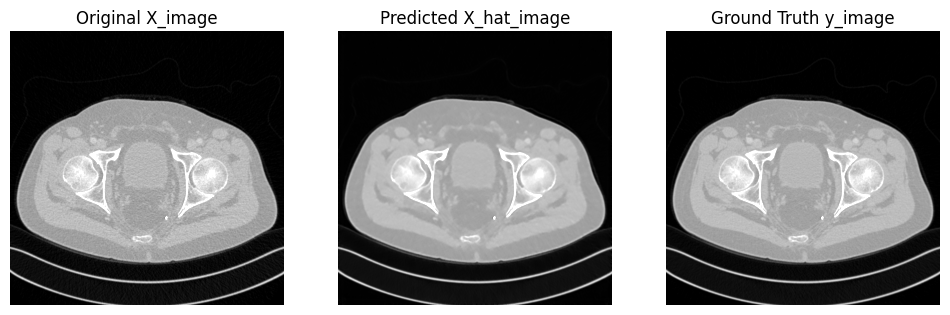

In [67]:
# 1. 가장 좋은 값 가져오기
X_test, y_test, X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
img = trans_img(X_test)
p1, p99 = np.percentile(img, (1, 99))
axes[0].imshow(img, cmap='gray', vmin=p1, vmax=p99)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
img_hat = trans_img(X_hat)
p1_hat, p99_hat = np.percentile(img_hat, (1, 99))
axes[1].imshow(img_hat, cmap='gray', vmin=p1_hat, vmax=p99_hat)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
img_y = trans_img(y_test)
p1_y, p99_y = np.percentile(img_y, (1, 99))
axes[2].imshow(img_y, cmap='gray', vmin=p1_y, vmax=p99_y)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

# 이미지 저장
save_img(X_test, X_hat, y_test, 'best')

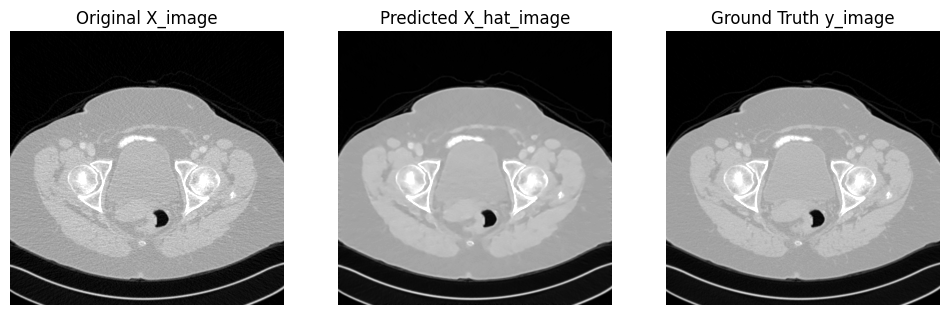

In [68]:
# 2. 가장 나쁜 값 가져오기
X_test, y_test, X_hat = worst

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
img = trans_img(X_test)
p1, p99 = np.percentile(img, (1, 99))
axes[0].imshow(img, cmap='gray', vmin=p1, vmax=p99)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
img_hat = trans_img(X_hat)
p1_hat, p99_hat = np.percentile(img_hat, (1, 99))
axes[1].imshow(img_hat, cmap='gray', vmin=p1_hat, vmax=p99_hat)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
img_y = trans_img(y_test)
p1_y, p99_y = np.percentile(img_y, (1, 99))
axes[2].imshow(img_y, cmap='gray', vmin=p1_y, vmax=p99_y)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

# 이미지 저장
save_img(X_test, X_hat, y_test, 'worst')

In [69]:
# rmse, psnr, ssim 구하기

import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
model_path = '/root/base/whole/red_cnn_base.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load(model_path))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:   9%|▊         | 104/1190 [00:04<00:46, 23.35it/s]

RMSE per interval: 0.0110, PSNR per interval: 39.27, SSIM per interval: 0.9300


Evaluating:  17%|█▋        | 203/1190 [00:08<00:42, 23.33it/s]

RMSE per interval: 0.0068, PSNR per interval: 43.55, SSIM per interval: 0.9660


Evaluating:  25%|██▌       | 302/1190 [00:12<00:37, 23.46it/s]

RMSE per interval: 0.0086, PSNR per interval: 41.43, SSIM per interval: 0.9518


Evaluating:  34%|███▍      | 404/1190 [00:17<00:33, 23.44it/s]

RMSE per interval: 0.0124, PSNR per interval: 38.34, SSIM per interval: 0.9177


Evaluating:  42%|████▏     | 503/1190 [00:21<00:29, 23.13it/s]

RMSE per interval: 0.0120, PSNR per interval: 38.79, SSIM per interval: 0.9337


Evaluating:  51%|█████     | 602/1190 [00:25<00:25, 23.24it/s]

RMSE per interval: 0.0086, PSNR per interval: 41.51, SSIM per interval: 0.9564


Evaluating:  59%|█████▉    | 704/1190 [00:30<00:20, 23.50it/s]

RMSE per interval: 0.0090, PSNR per interval: 41.02, SSIM per interval: 0.9561


Evaluating:  67%|██████▋   | 803/1190 [00:34<00:16, 23.29it/s]

RMSE per interval: 0.0091, PSNR per interval: 41.15, SSIM per interval: 0.9515


Evaluating:  76%|███████▌  | 902/1190 [00:38<00:12, 23.46it/s]

RMSE per interval: 0.0094, PSNR per interval: 40.82, SSIM per interval: 0.9458


Evaluating:  84%|████████▍ | 1004/1190 [00:42<00:07, 23.46it/s]

RMSE per interval: 0.0085, PSNR per interval: 41.48, SSIM per interval: 0.9543


Evaluating:  93%|█████████▎| 1103/1190 [00:47<00:03, 22.75it/s]

RMSE per interval: 0.0083, PSNR per interval: 41.71, SSIM per interval: 0.9556


Evaluating: 100%|██████████| 1190/1190 [00:51<00:00, 23.14it/s]

Average RMSE over all intervals: 0.009418


In [72]:
import os
import numpy as np

s = '/root/base/whole/metric/'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the {s} folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the /root/base/whole/metric/ folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


### 클러스터링 그룹0 에 대해

In [73]:
cluster_id = 0

criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('/root/base/whole/red_cnn_base.pth'))

<All keys matched successfully>

In [74]:
from torch.utils.data import DataLoader
test_path = f'/root/cluster/c{cluster_id}/whole/test_dataset.pt'
test_dataset = torch.load(test_path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

391

In [75]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  27%|██▋       | 104/391 [00:03<00:08, 33.40it/s]

train loss : 8.315781193232396e-05


Evaluating:  52%|█████▏    | 204/391 [00:06<00:05, 33.57it/s]

train loss : 0.0001260563546748017


Evaluating:  78%|███████▊  | 304/391 [00:09<00:02, 33.46it/s]

train loss : 0.00013540419035052765


Evaluating: 100%|██████████| 391/391 [00:12<00:00, 31.74it/s]


In [ ]:
# rmse, psnr, ssim 구하기

import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
model_path = '/root/base/whole/red_cnn_base.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load(model_path))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:   1%|          | 3/391 [00:00<00:18, 20.66it/s]

In [ ]:
import os
import numpy as np

s = f'/root/base/whole/c{cluster_id}/metric/'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the {s} folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the /root/base/whole/c0/metric/ folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


### 클러스터링 그룹1 에 대해

In [ ]:
cluster_id = 1

criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('/root/base/whole/red_cnn_base.pth'))

<All keys matched successfully>

In [ ]:
from torch.utils.data import DataLoader
test_path = f'/root/cluster/c{cluster_id}/whole/test_dataset.pt'
test_dataset = torch.load(test_path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

516

In [ ]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  20%|██        | 104/516 [00:03<00:12, 32.80it/s]

train loss : 0.00011069709427829366


Evaluating:  40%|███▉      | 204/516 [00:06<00:09, 32.78it/s]

train loss : 9.533248034131248e-05


Evaluating:  59%|█████▉    | 304/516 [00:09<00:06, 32.76it/s]

train loss : 7.586249677842715e-05


Evaluating:  78%|███████▊  | 404/516 [00:12<00:03, 32.84it/s]

train loss : 7.16695903611253e-05


Evaluating:  98%|█████████▊| 504/516 [00:15<00:00, 32.75it/s]

train loss : 6.325643716991181e-05


Evaluating: 100%|██████████| 516/516 [00:16<00:00, 31.68it/s]


In [ ]:
# rmse, psnr, ssim 구하기

import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
model_path = '/root/base/whole/red_cnn_base.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load(model_path))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  20%|██        | 104/516 [00:04<00:18, 22.48it/s]

RMSE per interval: 0.0103, PSNR per interval: 39.98, SSIM per interval: 0.9493


Evaluating:  39%|███▉      | 203/516 [00:09<00:13, 22.41it/s]

RMSE per interval: 0.0093, PSNR per interval: 40.89, SSIM per interval: 0.9511


Evaluating:  59%|█████▊    | 302/516 [00:13<00:09, 22.40it/s]

RMSE per interval: 0.0086, PSNR per interval: 41.43, SSIM per interval: 0.9570


Evaluating:  78%|███████▊  | 404/516 [00:18<00:05, 22.39it/s]

RMSE per interval: 0.0083, PSNR per interval: 41.71, SSIM per interval: 0.9564


Evaluating:  97%|█████████▋| 503/516 [00:22<00:00, 22.38it/s]

RMSE per interval: 0.0077, PSNR per interval: 42.46, SSIM per interval: 0.9636


Evaluating: 100%|██████████| 516/516 [00:23<00:00, 21.91it/s]

Average RMSE over all intervals: 0.008851


In [ ]:
import os
import numpy as np

s = f'/root/base/whole/c{cluster_id}/metric/'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the {s} folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the /root/base/whole/c1/metric/ folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


### 클러스터링 그룹2 에 대해

In [ ]:
cluster_id = 2

criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('/root/base/whole/red_cnn_base.pth'))

<All keys matched successfully>

In [ ]:
from torch.utils.data import DataLoader
test_path = f'/root/cluster/c{cluster_id}/whole/test_dataset.pt'
test_dataset = torch.load(test_path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

293

In [ ]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  35%|███▌      | 104/293 [00:03<00:05, 32.67it/s]

train loss : 9.660541531047784e-05


Evaluating:  70%|██████▉   | 204/293 [00:06<00:02, 32.65it/s]

train loss : 0.00012895434199890587


Evaluating: 100%|██████████| 293/293 [00:09<00:00, 30.76it/s]


In [ ]:
# rmse, psnr, ssim 구하기

import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
model_path = '/root/base/whole/red_cnn_base.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load(model_path))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  35%|███▌      | 104/293 [00:04<00:08, 22.49it/s]

RMSE per interval: 0.0097, PSNR per interval: 40.30, SSIM per interval: 0.9492


Evaluating:  69%|██████▉   | 203/293 [00:09<00:04, 22.44it/s]

RMSE per interval: 0.0108, PSNR per interval: 39.77, SSIM per interval: 0.9438


Evaluating: 100%|██████████| 293/293 [00:13<00:00, 21.51it/s]

Average RMSE over all intervals: 0.010254


In [ ]:
import os
import numpy as np

s = f'/root/base/whole/c{cluster_id}/metric/'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the {s} folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the /root/base/whole/c2/metric/ folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 클러스터링 모델별 학습

In [18]:
%cd cluster

/root/cluster


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [19]:
!pwd

/root/cluster


## 함수선언

In [20]:
def normlize(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept

    # CT 값 클리핑 (일반적인 HU 범위: -1000~3000) <- 극단적인 값 제거를 위해
    img = np.clip(img, -1000, 3000) # 3000이 넘어가면 3000으로 바꿈

    # 정규화 (0~1 사이로)
    scaled_img = (img - img.min()) / (img.max() - img.min())
    
    # 제일 앞에 1차원 넣기
    img = np.expand_dims(scaled_img, axis=0)

    return img # 1x512x512

In [21]:
# Mayo 2016 데이터셋에서 DICOM 파일 찾기
base_folder = "/root/mayo2016"
img_type = "quarter_1mm"
dicom_files = []

# 모든 L0xx 폴더에서 DICOM 파일 수집
L_patients = L_list
for patient_id in L_patients:
    patient_folder = os.path.join(base_folder, patient_id, "quarter_1mm") # quarter_1mm
    if os.path.exists(patient_folder):
        patient_files = [os.path.join(patient_folder, f) 
                        for f in os.listdir(patient_folder) 
                        if f.endswith(".IMA")]
        dicom_files.extend(patient_files)

In [22]:
img = normlize(dicom_files[0])
img.shape, img.max(), img.min() # 0~1 사이어야 유리하다.

((1, 512, 512), 1.0, 0.0)

In [23]:
def extract_patches(img, patch_size=512, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55

추출된 패치 수: 1
각 패치의 크기: (1, 512, 512)


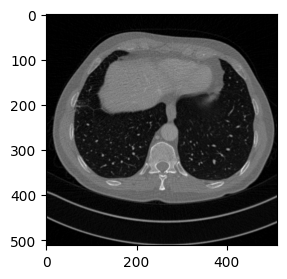

In [24]:
# 1x512x512 이미지에서 1x55x55 패치 추출
patch_size = 512
interval = 55
patches = extract_patches(img, patch_size, interval)

print(f"추출된 패치 수: {len(patches)}")
print(f"각 패치의 크기: {patches[0].shape}")

# 이미지 확인
plt.imshow(np.squeeze(patches[0]), cmap='gray')
plt.show()

In [25]:
from scipy.ndimage import rotate, zoom
import random

def augment_patches(X_patches, y_patches, p=0.5):
    
    X_augmented_patches, y_augmented_patches = [], []
    
    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [26]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=512, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=512, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  # X_augmented_patches = torch.from_numpy(X_augmented_patches).float()  # dtype=float 변환 추가
  # y_augmented_patches = torch.from_numpy(y_augmented_patches).float()
  return X_augmented_patches, y_augmented_patches

In [27]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=512, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=512, interval=55)
  # X_patches = torch.from_numpy(X_patches).float()  # dtype=float 변환 추가
  # y_patches = torch.from_numpy(y_patches).float()
  return X_patches, y_patches

In [28]:
i,j = 0,0
X_dir = sorted(glob.glob(f'/root/mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
y_dir = sorted(glob.glob(f'/root/mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]

X_patches, y_patches = patch_maker_W_aug(X_dir, y_dir)
print(X_patches.shape, y_patches.shape) # 3배 정도 늘어남

X_patches, y_patches = patch_maker_WO_aug(X_dir, y_dir)
print(X_patches.shape, y_patches.shape) # 1배 (기본)

(4, 1, 512, 512) (4, 1, 512, 512)
(1, 1, 512, 512) (1, 1, 512, 512)


## 데이터셋 정의 및 저장

In [29]:
import os
import pandas as pd
import torch
import glob
from torch.utils.data import Dataset
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, df_clusters, cluster_id, L_list=L_list, data_label=data_label):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.df_clusters = df_clusters
        self.cluster_id = cluster_id
        self.L_list = L_list
        self.data_label = data_label
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir
            y_dir_list += y_dir

        for X_dir, y_dir in tqdm(zip(X_dir_list, y_dir_list), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            for i in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[i]), torch.from_numpy(y_patches[i])  # torch 변환
                self.image_pairs.append((X_patch, y_patch))

    def get_data_range(self, L):
        """클러스터 ID에 해당하는 파일만 선택 (y_dir은 x_dir의 인덱스에 맞게 선택)"""
        X_dir = sorted(glob.glob(f'/root/mayo2016/{L}/{self.data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'/root/mayo2016/{L}/{self.data_label[1]}/*.IMA'))

        # 클러스터 ID에 해당하는 X 파일만 필터링
        cluster_files = set(self.df_clusters[self.df_clusters["Cluster Label"] == self.cluster_id]["DICOM Location"].values)
        X_filtered = [x for x in X_dir if x in cluster_files]

        # X_filtered에서 선택된 파일들의 인덱스를 기준으로 y_dir도 선택
        X_indices = [X_dir.index(x) for x in X_filtered]  # 선택된 x의 인덱스
        y_filtered = [y_dir[i] for i in X_indices]  # 같은 인덱스를 사용하여 y 선택

        n1, n2 = len(X_filtered), len(y_filtered)
        if self.data_type == 'train':
            X_range = X_filtered[:int(n1 * 0.64)]
            y_range = y_filtered[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_filtered[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_filtered[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_filtered[int(n1 * 0.8):]
            y_range = y_filtered[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = self.image_pairs[idx][0]
        y = self.image_pairs[idx][1]
        return X, y

In [30]:
import pandas as pd
df_clusters = pd.read_csv("/root/df_clusters.csv")
df_clusters.head()

DICOM Location  Cluster Label
0  /root/mayo2016/L067/quarter_1mm/L067_QD_1_1.CT...              2
1  /root/mayo2016/L067/quarter_1mm/L067_QD_1_1.CT...              1
2  /root/mayo2016/L067/quarter_1mm/L067_QD_1_1.CT...              1
3  /root/mayo2016/L067/quarter_1mm/L067_QD_1_1.CT...              1
4  /root/mayo2016/L067/quarter_1mm/L067_QD_1_1.CT...              2

In [31]:
df_clusters.loc[:,'Cluster Label'].unique()

array([2, 1, 0])

In [32]:
df_clusters.shape

(5936, 2)

In [33]:
num = 0
for L in L_list:
    for label in data_label:
        num += len(glob.glob(f'/root/mayo2016/{L}/{label}/*.IMA'))
num/2

5936.0

In [34]:
cluster_id = 0

patch_folder = f"/root/cluster/c{cluster_id}/whole/"
train_path = patch_folder+'train_dataset.pt'
val_path = patch_folder+'val_dataset.pt'
test_path = patch_folder+'test_dataset.pt'

train_dataset = CustomDataset(data_type='train', patch_maker=patch_maker_W_aug, df_clusters=df_clusters, cluster_id=cluster_id)
val_dataset = CustomDataset(data_type='val', patch_maker=patch_maker_WO_aug, df_clusters=df_clusters, cluster_id=cluster_id)
test_dataset = CustomDataset(data_type='test', patch_maker=patch_maker_WO_aug, df_clusters=df_clusters, cluster_id=cluster_id)

# 데이터셋 저장
torch.save(train_dataset, train_path)
torch.save(val_dataset, val_path)
torch.save(test_dataset, test_path)

test is processing: 100%|██████████| 391/391 [00:01<00:00, 201.90it/s]


In [35]:
cluster_id = 1

patch_folder = f"/root/cluster/c{cluster_id}/whole/"
train_path = patch_folder+'train_dataset.pt'
val_path = patch_folder+'val_dataset.pt'
test_path = patch_folder+'test_dataset.pt'

train_dataset = CustomDataset(data_type='train', patch_maker=patch_maker_W_aug, df_clusters=df_clusters, cluster_id=cluster_id)
val_dataset = CustomDataset(data_type='val', patch_maker=patch_maker_WO_aug, df_clusters=df_clusters, cluster_id=cluster_id)
test_dataset = CustomDataset(data_type='test', patch_maker=patch_maker_WO_aug, df_clusters=df_clusters, cluster_id=cluster_id)

# 데이터셋 저장
torch.save(train_dataset, train_path)
torch.save(val_dataset, val_path)
torch.save(test_dataset, test_path)

train is processing:   0%|          | 0/1633 [00:00<?, ?it/s]

test is processing: 100%|██████████| 516/516 [00:02<00:00, 206.29it/s]


In [36]:
cluster_id = 2

patch_folder = f"/root/cluster/c{cluster_id}/whole/"
train_path = patch_folder+'train_dataset.pt'
val_path = patch_folder+'val_dataset.pt'
test_path = patch_folder+'test_dataset.pt'

train_dataset = CustomDataset(data_type='train', patch_maker=patch_maker_W_aug, df_clusters=df_clusters, cluster_id=cluster_id)
val_dataset = CustomDataset(data_type='val', patch_maker=patch_maker_WO_aug, df_clusters=df_clusters, cluster_id=cluster_id)
test_dataset = CustomDataset(data_type='test', patch_maker=patch_maker_WO_aug, df_clusters=df_clusters, cluster_id=cluster_id)

# 데이터셋 저장
torch.save(train_dataset, train_path)
torch.save(val_dataset, val_path)
torch.save(test_dataset, test_path)

train is processing:   0%|          | 0/915 [00:00<?, ?it/s]

test is processing: 100%|██████████| 293/293 [00:01<00:00, 186.16it/s]


## 학습

### 클러스터 0 모델 학습

In [37]:
cluster_id = 0
epochs = 2

In [38]:
# 데이터셋 불러오기

patch_folder = f"/root/cluster/c{cluster_id}/whole/"
train_path = patch_folder+'train_dataset.pt'
val_path = patch_folder+'val_dataset.pt'
test_path = patch_folder+'test_dataset.pt'

train_dataset = torch.load(train_path)
val_dataset = torch.load(val_path)
test_dataset = torch.load(test_path)

In [39]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)

(3708, 312, 391)

In [40]:
X_train, y_train = next(iter(train_loader))
X_train.shape, y_train.shape

(torch.Size([1, 1, 512, 512]), torch.Size([1, 1, 512, 512]))

In [41]:
def visualize_patches(X, y):
    fig, axes = plt.subplots(1, 2, figsize=(4, 8))  # 2행 16열로 설정

    # X 데이터 시각화
    axes[0].imshow(np.squeeze(X), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f"X", fontsize=10)
    
    # y 데이터 시각화
    axes[1].imshow(np.squeeze(y), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f"y", fontsize=10)
    
    plt.tight_layout()
    plt.show()

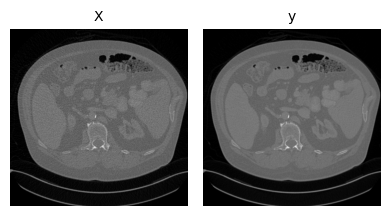

In [42]:
visualize_patches(X_train, y_train)

In [43]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [44]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)
        
        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()


    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))
        
        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결
        
        return x

In [45]:
model = RedCNN().to(device)

In [46]:
%cd /root

/root


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [47]:
import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [48]:
import torch
from tqdm import tqdm

interval = 100

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            running_loss += loss.item() * X.size(0)

            if i % interval == interval-1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                total_loss += running_loss
                running_loss = 0.0
                tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)

In [49]:
model_name = f'/root/cluster/c{cluster_id}/whole/red_cnn_c{cluster_id}'
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), f"{model_name}.pth")
        print('model is saving...')

Epoch 0 - Training:   3%|▎         | 101/3708 [00:12<05:33, 10.82it/s]

train loss : 0.0006937224794819485


Epoch 0 - Training:   5%|▌         | 201/3708 [00:21<05:25, 10.77it/s]

train loss : 0.0003697164166806033


Epoch 0 - Training:   8%|▊         | 301/3708 [00:31<05:17, 10.74it/s]

train loss : 0.00030127169186016544


Epoch 0 - Training:  11%|█         | 401/3708 [00:40<05:09, 10.67it/s]

train loss : 0.00032073901740659494


Epoch 0 - Training:  14%|█▎        | 501/3708 [00:49<05:01, 10.64it/s]

train loss : 0.00028479274889832597


Epoch 0 - Training:  16%|█▌        | 601/3708 [00:59<04:52, 10.63it/s]

train loss : 0.000276135108579183


Epoch 0 - Training:  19%|█▉        | 701/3708 [01:08<04:43, 10.59it/s]

train loss : 0.00028122169031121304


Epoch 0 - Training:  22%|██▏       | 801/3708 [01:17<04:34, 10.59it/s]

train loss : 0.0002917421650272445


Epoch 0 - Training:  24%|██▍       | 901/3708 [01:27<04:25, 10.57it/s]

train loss : 0.00023501553710957523


Epoch 0 - Training:  27%|██▋       | 1001/3708 [01:36<04:16, 10.56it/s]

train loss : 0.0002747784409075393


Epoch 0 - Training:  30%|██▉       | 1101/3708 [01:46<04:06, 10.56it/s]

train loss : 0.00022976437328907197


Epoch 0 - Training:  32%|███▏      | 1201/3708 [01:55<03:57, 10.55it/s]

train loss : 0.00028517694692709484


Epoch 0 - Training:  35%|███▌      | 1301/3708 [02:04<03:48, 10.55it/s]

train loss : 0.00019874553614499747


Epoch 0 - Training:  38%|███▊      | 1401/3708 [02:14<03:38, 10.55it/s]

train loss : 0.00022257578213611851


Epoch 0 - Training:  40%|████      | 1501/3708 [02:23<03:29, 10.51it/s]

train loss : 0.00021035259611380753


Epoch 0 - Training:  43%|████▎     | 1601/3708 [02:33<03:19, 10.54it/s]

train loss : 0.0002485519726178609


Epoch 0 - Training:  46%|████▌     | 1701/3708 [02:42<03:10, 10.54it/s]

train loss : 0.00022757763286790578


Epoch 0 - Training:  49%|████▊     | 1801/3708 [02:52<03:00, 10.55it/s]

train loss : 0.00021302974899299444


Epoch 0 - Training:  51%|█████▏    | 1901/3708 [03:01<02:51, 10.55it/s]

train loss : 0.0002664828552224208


Epoch 0 - Training:  54%|█████▍    | 2001/3708 [03:11<02:42, 10.53it/s]

train loss : 0.00020565993705531582


Epoch 0 - Training:  57%|█████▋    | 2101/3708 [03:20<02:32, 10.52it/s]

train loss : 0.00022250730035011657


Epoch 0 - Training:  59%|█████▉    | 2201/3708 [03:30<02:23, 10.53it/s]

train loss : 0.000234109065568191


Epoch 0 - Training:  62%|██████▏   | 2301/3708 [03:39<02:13, 10.53it/s]

train loss : 0.00019552258392650402


Epoch 0 - Training:  65%|██████▍   | 2401/3708 [03:49<02:03, 10.54it/s]

train loss : 0.0002190740355217713


Epoch 0 - Training:  67%|██████▋   | 2501/3708 [03:58<01:54, 10.52it/s]

train loss : 0.00019769657574215672


Epoch 0 - Training:  70%|███████   | 2601/3708 [04:07<01:45, 10.51it/s]

train loss : 0.00016959113261691528


Epoch 0 - Training:  73%|███████▎  | 2701/3708 [04:17<01:35, 10.53it/s]

train loss : 0.00020235015290381853


Epoch 0 - Training:  76%|███████▌  | 2801/3708 [04:26<01:26, 10.54it/s]

train loss : 0.00018682577967410908


Epoch 0 - Training:  78%|███████▊  | 2901/3708 [04:36<01:16, 10.52it/s]

train loss : 0.00018298809198313392


Epoch 0 - Training:  81%|████████  | 3001/3708 [04:45<01:07, 10.44it/s]

train loss : 0.0002463274906767765


Epoch 0 - Training:  84%|████████▎ | 3101/3708 [04:55<00:57, 10.53it/s]

train loss : 0.0001758224361037719


Epoch 0 - Training:  86%|████████▋ | 3201/3708 [05:04<00:48, 10.52it/s]

train loss : 0.00015897147706709803


Epoch 0 - Training:  89%|████████▉ | 3301/3708 [05:14<00:38, 10.52it/s]

train loss : 0.00019816881158476462


Epoch 0 - Training:  92%|█████████▏| 3401/3708 [05:23<00:29, 10.52it/s]

train loss : 0.00018156857357098488


Epoch 0 - Training:  94%|█████████▍| 3501/3708 [05:33<00:19, 10.58it/s]

train loss : 0.0001994331113746739


Epoch 0 - Training:  97%|█████████▋| 3601/3708 [05:42<00:10, 10.57it/s]

train loss : 0.00017546768562169744


Epoch 0 - Training: 100%|█████████▉| 3701/3708 [05:51<00:00, 10.52it/s]

train loss : 0.0001666754135658266


Epoch 0 - Evaluating:  33%|███▎      | 104/312 [00:03<00:06, 32.45it/s]

train loss : 0.00014056615000299644


Epoch 0 - Evaluating:  65%|██████▌   | 204/312 [00:06<00:03, 32.44it/s]

train loss : 0.00013679626252269372


Epoch 0 - Evaluating:  97%|█████████▋| 304/312 [00:09<00:00, 32.52it/s]

train loss : 0.00017041375889675692


Epoch 0 - Evaluating: 100%|██████████| 312/312 [00:09<00:00, 31.25it/s]

Epoch [1/2], Train Loss: 0.0002, Valid Loss: 0.0001
model is saving...



Epoch 1 - Training:   3%|▎         | 102/3708 [00:09<05:40, 10.59it/s]

train loss : 0.00018667229684069753


Epoch 1 - Training:   5%|▌         | 202/3708 [00:19<05:30, 10.60it/s]

train loss : 0.00021567879904978325


Epoch 1 - Training:   8%|▊         | 302/3708 [00:28<05:21, 10.60it/s]

train loss : 0.00022096939610491973


Epoch 1 - Training:  11%|█         | 402/3708 [00:37<05:12, 10.58it/s]

train loss : 0.0001753653482592199


Epoch 1 - Training:  14%|█▎        | 502/3708 [00:47<05:02, 10.59it/s]

train loss : 0.00018899969556514405


Epoch 1 - Training:  16%|█▌        | 602/3708 [00:56<04:53, 10.59it/s]

train loss : 0.00018010274689004291


Epoch 1 - Training:  19%|█▉        | 702/3708 [01:06<04:44, 10.58it/s]

train loss : 0.000201024080379284


Epoch 1 - Training:  22%|██▏       | 802/3708 [01:15<04:34, 10.60it/s]

train loss : 0.00015943218470056307


Epoch 1 - Training:  24%|██▍       | 902/3708 [01:25<04:25, 10.58it/s]

train loss : 0.00019508627799950774


Epoch 1 - Training:  27%|██▋       | 1002/3708 [01:34<04:15, 10.58it/s]

train loss : 0.00017231072422873694


Epoch 1 - Training:  30%|██▉       | 1102/3708 [01:43<04:06, 10.58it/s]

train loss : 0.00017605457611352904


Epoch 1 - Training:  32%|███▏      | 1202/3708 [01:53<03:56, 10.59it/s]

train loss : 0.00018753389442281333


Epoch 1 - Training:  35%|███▌      | 1302/3708 [02:02<03:46, 10.60it/s]

train loss : 0.0001974206597878947


Epoch 1 - Training:  38%|███▊      | 1402/3708 [02:12<03:37, 10.61it/s]

train loss : 0.00020888972121611005


Epoch 1 - Training:  41%|████      | 1502/3708 [02:21<03:28, 10.59it/s]

train loss : 0.0001844430371420458


Epoch 1 - Training:  43%|████▎     | 1602/3708 [02:31<03:18, 10.60it/s]

train loss : 0.00019672618134791264


Epoch 1 - Training:  46%|████▌     | 1702/3708 [02:40<03:09, 10.60it/s]

train loss : 0.0001847953931974189


Epoch 1 - Training:  49%|████▊     | 1802/3708 [02:49<02:59, 10.59it/s]

train loss : 0.00016333541796484497


Epoch 1 - Training:  51%|█████▏    | 1902/3708 [02:59<02:50, 10.59it/s]

train loss : 0.0001863012390458607


Epoch 1 - Training:  54%|█████▍    | 2002/3708 [03:08<02:41, 10.59it/s]

train loss : 0.00017550954264152095


Epoch 1 - Training:  57%|█████▋    | 2102/3708 [03:18<02:31, 10.60it/s]

train loss : 0.00018470925388101023


Epoch 1 - Training:  59%|█████▉    | 2202/3708 [03:27<02:22, 10.56it/s]

train loss : 0.00017197595931065735


Epoch 1 - Training:  62%|██████▏   | 2302/3708 [03:37<02:13, 10.56it/s]

train loss : 0.00018725298599747475


Epoch 1 - Training:  65%|██████▍   | 2402/3708 [03:46<02:03, 10.55it/s]

train loss : 0.00015426610480062664


Epoch 1 - Training:  67%|██████▋   | 2502/3708 [03:56<01:54, 10.50it/s]

train loss : 0.00016472128683744813


Epoch 1 - Training:  70%|███████   | 2602/3708 [04:05<01:44, 10.59it/s]

train loss : 0.0001628355452339747


Epoch 1 - Training:  73%|███████▎  | 2702/3708 [04:14<01:35, 10.55it/s]

train loss : 0.00017027975689416053


Epoch 1 - Training:  76%|███████▌  | 2802/3708 [04:24<01:25, 10.56it/s]

train loss : 0.00017297546299232635


Epoch 1 - Training:  78%|███████▊  | 2902/3708 [04:33<01:16, 10.58it/s]

train loss : 0.00017631530019571073


Epoch 1 - Training:  81%|████████  | 3002/3708 [04:43<01:06, 10.60it/s]

train loss : 0.00015917752414679854


Epoch 1 - Training:  84%|████████▎ | 3102/3708 [04:52<00:57, 10.59it/s]

train loss : 0.00016640808196825675


Epoch 1 - Training:  86%|████████▋ | 3202/3708 [05:02<00:47, 10.60it/s]

train loss : 0.00017748578278769855


Epoch 1 - Training:  89%|████████▉ | 3302/3708 [05:11<00:38, 10.59it/s]

train loss : 0.00017209655059559735


Epoch 1 - Training:  92%|█████████▏| 3402/3708 [05:20<00:28, 10.59it/s]

train loss : 0.00017855105532362358


Epoch 1 - Training:  94%|█████████▍| 3502/3708 [05:30<00:19, 10.60it/s]

train loss : 0.00016190982925763818


Epoch 1 - Training:  97%|█████████▋| 3602/3708 [05:39<00:10, 10.57it/s]

train loss : 0.00015062564565596404


Epoch 1 - Training: 100%|█████████▉| 3702/3708 [05:49<00:00, 10.57it/s]

train loss : 0.00016890701175725553


Epoch 1 - Evaluating:  33%|███▎      | 104/312 [00:03<00:06, 32.48it/s]

train loss : 0.00011516934111568844


Epoch 1 - Evaluating:  65%|██████▌   | 204/312 [00:06<00:03, 32.49it/s]

train loss : 0.00011339340529957553


Epoch 1 - Evaluating:  97%|█████████▋| 304/312 [00:09<00:00, 32.47it/s]

train loss : 0.0001458995467692148


Epoch 1 - Evaluating: 100%|██████████| 312/312 [00:09<00:00, 31.27it/s]

Epoch [2/2], Train Loss: 0.0002, Valid Loss: 0.0001
model is saving...


In [50]:
!pwd

/root


In [51]:
%cd '/root/cluster/c{cluster_id}/whole'

/root/cluster/c0/whole


In [52]:
!pwd

/root/cluster/c0/whole


In [53]:
import pickle

data_to_save = {
    'train_loss_per_iter': train_loss_per_iter,
    'val_loss_per_iter': val_loss_per_iter,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch
}

for filename, data in data_to_save.items():
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [54]:
import pickle

filenames = [
    'train_loss_per_iter.pkl',
    'val_loss_per_iter.pkl',
    'train_loss_per_epoch.pkl',
    'val_loss_per_epoch.pkl'
]

variables = [
    'train_loss_per_iter',
    'val_loss_per_iter',
    'train_loss_per_epoch',
    'val_loss_per_epoch'
]

data_to_load = dict(zip(filenames, variables))

for filename, variable_name in data_to_load.items():
    with open(filename, 'rb') as f:
        globals()[variable_name] = pickle.load(f)

In [55]:
train_flatten, val_flatten = [item for sublist in train_loss_per_iter for item in sublist], [item for sublist in val_loss_per_iter for item in sublist]

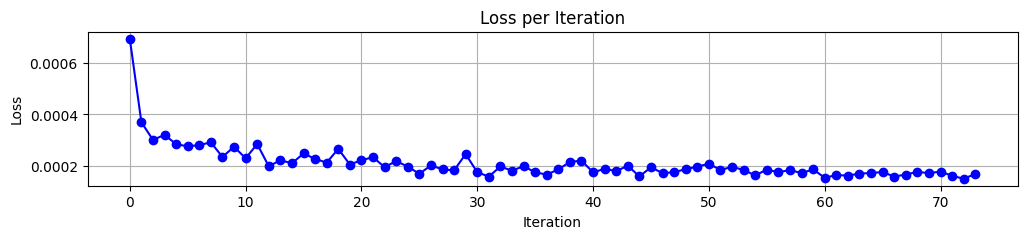

In [56]:
plt.figure(figsize=(12, 2))

# 반복 단위 손실 그래프
plt.plot(train_flatten, label='Train (per iter)', linestyle='-', marker='o', color='blue')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

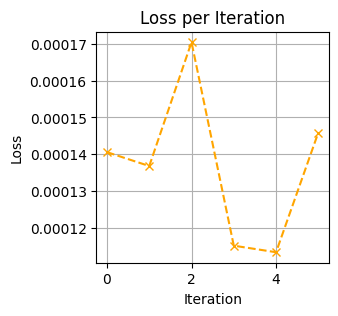

In [57]:
plt.plot(val_flatten, label='Validation (per iter)', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

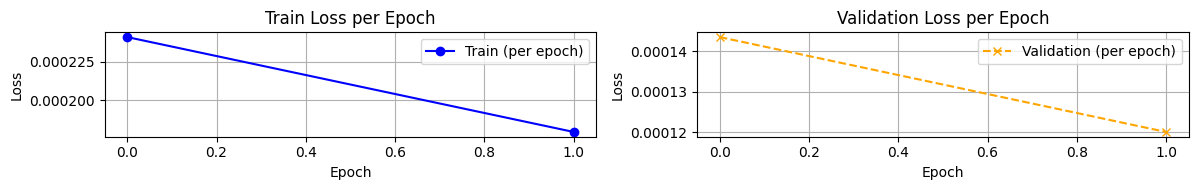

In [58]:
# 1행 2열 레이아웃 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 2))  # 그래프 크기 조정

# Train loss per epoch 그래프
axes[0].plot(train_loss_per_epoch, label='Train (per epoch)', linestyle='-', marker='o', color='blue')
axes[0].set_title("Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# Validation loss per epoch 그래프
axes[1].plot(val_loss_per_epoch, label='Validation (per epoch)', linestyle='--', marker='x', color='orange')
axes[1].set_title("Validation Loss per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

In [59]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [60]:
# cluster_id = 0
criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model_name = f'/root/cluster/c{cluster_id}/red_cnn_c{cluster_id}.pth'
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [61]:
from torch.utils.data import DataLoader
test_path = f'/root/cluster/c{cluster_id}/whole/test_dataset.pt'
test_dataset = torch.load(test_path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

391

In [62]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  27%|██▋       | 104/391 [00:03<00:08, 32.57it/s]

train loss : 7.592236603159109e-05


Evaluating:  52%|█████▏    | 204/391 [00:06<00:05, 32.58it/s]

train loss : 0.00011397256161217228


Evaluating:  78%|███████▊  | 304/391 [00:09<00:02, 32.60it/s]

train loss : 0.0001258521544332325


Evaluating: 100%|██████████| 391/391 [00:12<00:00, 31.39it/s]


In [63]:
def rescale(normalized_img, original_min=-1000, original_max=3000):
    """
    정규화된 이미지를 원래 HU 범위로 복원하는 함수

    :param normalized_img: 정규화된 이미지 (0~1)
    :param original_min: 원본 HU 최소값
    :param original_max: 원본 HU 최대값
    :return: 원래 HU 값으로 복원된 이미지
    """
    restored_img = normalized_img * (original_max - original_min) + original_min
    return restored_img

def trans_img(X):
    return rescale(np.squeeze(X.cpu()))

def save_img(X_test, X_hat, y_test, s):
    # X_test 저장
    numpy_X_test = trans_img(X_test).numpy()
    np.save(f'X_test_image{s}.npy', numpy_X_test)
    
    # X_hat 저장
    numpy_X_hat = trans_img(X_hat).numpy()
    np.save(f'X_hat_image{s}.npy', numpy_X_hat)
    
    # y_test 저장
    numpy_y_test = trans_img(y_test).numpy()
    np.save(f'y_test_image{s}.npy', numpy_y_test)

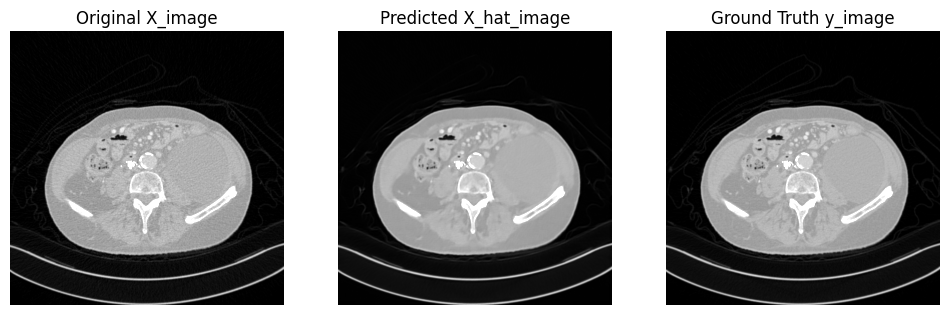

In [64]:
# 1. 가장 좋은 값 가져오기
X_test, y_test, X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
img = trans_img(X_test)
p1, p99 = np.percentile(img, (1, 99))
axes[0].imshow(img, cmap='gray', vmin=p1, vmax=p99)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
img_hat = trans_img(X_hat)
p1_hat, p99_hat = np.percentile(img_hat, (1, 99))
axes[1].imshow(img_hat, cmap='gray', vmin=p1_hat, vmax=p99_hat)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
img_y = trans_img(y_test)
p1_y, p99_y = np.percentile(img_y, (1, 99))
axes[2].imshow(img_y, cmap='gray', vmin=p1_y, vmax=p99_y)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

# 이미지 저장
save_img(X_test, X_hat, y_test, 'best')

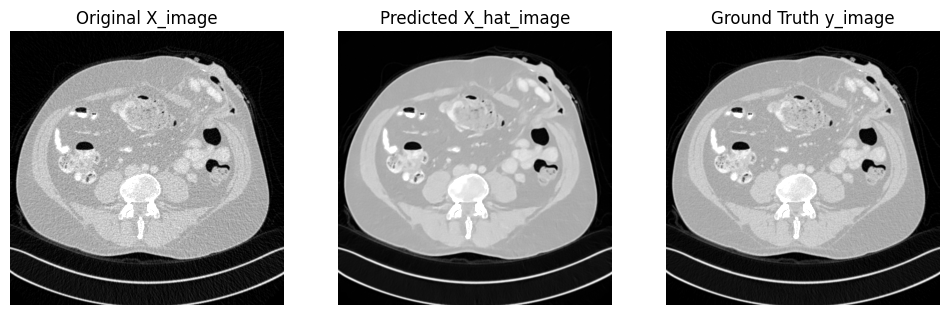

In [65]:
# 2. 가장 나쁜 값 가져오기
X_test, y_test, X_hat = worst

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
img = trans_img(X_test)
p1, p99 = np.percentile(img, (1, 99))
axes[0].imshow(img, cmap='gray', vmin=p1, vmax=p99)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
img_hat = trans_img(X_hat)
p1_hat, p99_hat = np.percentile(img_hat, (1, 99))
axes[1].imshow(img_hat, cmap='gray', vmin=p1_hat, vmax=p99_hat)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
img_y = trans_img(y_test)
p1_y, p99_y = np.percentile(img_y, (1, 99))
axes[2].imshow(img_y, cmap='gray', vmin=p1_y, vmax=p99_y)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

# 이미지 저장
save_img(X_test, X_hat, y_test, 'worst')

In [66]:
# rmse, psnr, ssim 구하기

import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
model_path = f'/root/cluster/c{cluster_id}/whole/red_cnn_c{cluster_id}.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load(model_path))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  27%|██▋       | 104/391 [00:04<00:12, 22.50it/s]

RMSE per interval: 0.0089, PSNR per interval: 41.30, SSIM per interval: 0.9550


Evaluating:  52%|█████▏    | 203/391 [00:09<00:08, 22.37it/s]

RMSE per interval: 0.0106, PSNR per interval: 39.88, SSIM per interval: 0.9318


Evaluating:  77%|███████▋  | 302/391 [00:13<00:03, 22.45it/s]

RMSE per interval: 0.0111, PSNR per interval: 39.56, SSIM per interval: 0.9338


Evaluating: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]

Average RMSE over all intervals: 0.010234


In [67]:
import os
import numpy as np

s = f'/root/cluster/c{cluster_id}/whole/metric/'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the {s} folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the /root/cluster/c0/whole/metric/ folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


### 클러스터 1 모델 학습

In [68]:
cluster_id = 1
epochs = 2

In [69]:
# 데이터셋 불러오기

patch_folder = f"/root/cluster/c{cluster_id}/whole/"
train_path = patch_folder+'train_dataset.pt'
val_path = patch_folder+'val_dataset.pt'
test_path = patch_folder+'test_dataset.pt'

train_dataset = torch.load(train_path)
val_dataset = torch.load(val_path)
test_dataset = torch.load(test_path)

In [70]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)

(4931, 412, 516)

In [71]:
X_train, y_train = next(iter(train_loader))
X_train.shape, y_train.shape

(torch.Size([1, 1, 512, 512]), torch.Size([1, 1, 512, 512]))

In [72]:
def visualize_patches(X, y):
    fig, axes = plt.subplots(1, 2, figsize=(4, 8))  # 2행 16열로 설정

    # X 데이터 시각화
    axes[0].imshow(np.squeeze(X), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f"X", fontsize=10)
    
    # y 데이터 시각화
    axes[1].imshow(np.squeeze(y), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f"y", fontsize=10)
    
    plt.tight_layout()
    plt.show()

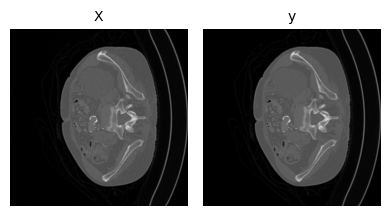

In [73]:
visualize_patches(X_train, y_train)

In [74]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [75]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)
        
        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()


    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))
        
        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결
        
        return x

In [76]:
model = RedCNN().to(device)

In [77]:
%cd /root

/root


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [78]:
import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [79]:
import torch
from tqdm import tqdm

interval = 100

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            running_loss += loss.item() * X.size(0)

            if i % interval == interval-1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                total_loss += running_loss
                running_loss = 0.0
                tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)

In [80]:
model_name = f'/root/cluster/c{cluster_id}/whole/red_cnn_c{cluster_id}'
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), f"{model_name}.pth")
        
        print('model is saving...')

Epoch 0 - Training:   2%|▏         | 102/4931 [00:09<07:29, 10.75it/s]

train loss : 0.0013732833799440414


Epoch 0 - Training:   4%|▍         | 202/4931 [00:18<07:21, 10.70it/s]

train loss : 0.0003209518657240551


Epoch 0 - Training:   6%|▌         | 302/4931 [00:28<07:12, 10.70it/s]

train loss : 0.00027270268226857296


Epoch 0 - Training:   8%|▊         | 402/4931 [00:37<07:04, 10.68it/s]

train loss : 0.0002423797697701957


Epoch 0 - Training:  10%|█         | 502/4931 [00:46<06:55, 10.66it/s]

train loss : 0.0002553073755552759


Epoch 0 - Training:  12%|█▏        | 602/4931 [00:56<06:46, 10.65it/s]

train loss : 0.0002793327100516763


Epoch 0 - Training:  14%|█▍        | 702/4931 [01:05<06:36, 10.65it/s]

train loss : 0.0002709936333121732


Epoch 0 - Training:  16%|█▋        | 802/4931 [01:14<06:27, 10.64it/s]

train loss : 0.0002566294998541707


Epoch 0 - Training:  18%|█▊        | 902/4931 [01:24<06:18, 10.63it/s]

train loss : 0.00023819906633434584


Epoch 0 - Training:  20%|██        | 1002/4931 [01:33<06:09, 10.63it/s]

train loss : 0.00018166431567806285


Epoch 0 - Training:  22%|██▏       | 1102/4931 [01:43<06:00, 10.63it/s]

train loss : 0.0001869678378352546


Epoch 0 - Training:  24%|██▍       | 1202/4931 [01:52<05:50, 10.63it/s]

train loss : 0.0001810564006154891


Epoch 0 - Training:  26%|██▋       | 1302/4931 [02:01<05:42, 10.59it/s]

train loss : 0.0001869607226763037


Epoch 0 - Training:  28%|██▊       | 1402/4931 [02:11<05:33, 10.57it/s]

train loss : 0.00016139958210260375


Epoch 0 - Training:  30%|███       | 1502/4931 [02:20<05:23, 10.61it/s]

train loss : 0.00020981394383852602


Epoch 0 - Training:  32%|███▏      | 1602/4931 [02:30<05:13, 10.61it/s]

train loss : 0.00016412787179433507


Epoch 0 - Training:  35%|███▍      | 1702/4931 [02:39<05:04, 10.61it/s]

train loss : 0.00016313001229718794


Epoch 0 - Training:  37%|███▋      | 1802/4931 [02:48<04:55, 10.58it/s]

train loss : 0.00014382871271664043


Epoch 0 - Training:  39%|███▊      | 1902/4931 [02:58<04:46, 10.56it/s]

train loss : 0.00016473728253913578


Epoch 0 - Training:  41%|████      | 2002/4931 [03:07<04:36, 10.60it/s]

train loss : 0.00017520617038826458


Epoch 0 - Training:  43%|████▎     | 2102/4931 [03:17<04:26, 10.61it/s]

train loss : 0.00023863936119596473


Epoch 0 - Training:  45%|████▍     | 2202/4931 [03:26<04:17, 10.61it/s]

train loss : 0.00019256889721873448


Epoch 0 - Training:  47%|████▋     | 2302/4931 [03:36<04:07, 10.61it/s]

train loss : 0.00015905152973573423


Epoch 0 - Training:  49%|████▊     | 2402/4931 [03:45<03:58, 10.60it/s]

train loss : 0.00015004701843281508


Epoch 0 - Training:  51%|█████     | 2502/4931 [03:54<03:49, 10.59it/s]

train loss : 0.0001404757325508399


Epoch 0 - Training:  53%|█████▎    | 2602/4931 [04:04<03:39, 10.61it/s]

train loss : 0.0001700860021810513


Epoch 0 - Training:  55%|█████▍    | 2702/4931 [04:13<03:30, 10.61it/s]

train loss : 0.00017667068026639755


Epoch 0 - Training:  57%|█████▋    | 2802/4931 [04:23<03:21, 10.56it/s]

train loss : 0.00014111988399236


Epoch 0 - Training:  59%|█████▉    | 2902/4931 [04:32<03:12, 10.57it/s]

train loss : 0.00014374350586876972


Epoch 0 - Training:  61%|██████    | 3002/4931 [04:42<03:02, 10.57it/s]

train loss : 0.00013654837406647857


Epoch 0 - Training:  63%|██████▎   | 3102/4931 [04:51<02:52, 10.58it/s]

train loss : 0.00014820257281826345


Epoch 0 - Training:  65%|██████▍   | 3202/4931 [05:00<02:43, 10.58it/s]

train loss : 0.0001948721212829696


Epoch 0 - Training:  67%|██████▋   | 3302/4931 [05:10<02:34, 10.57it/s]

train loss : 0.00015205533291009487


Epoch 0 - Training:  69%|██████▉   | 3402/4931 [05:19<02:24, 10.56it/s]

train loss : 0.0001322903062828118


Epoch 0 - Training:  71%|███████   | 3502/4931 [05:29<02:15, 10.56it/s]

train loss : 0.00012554167922644411


Epoch 0 - Training:  73%|███████▎  | 3602/4931 [05:38<02:05, 10.56it/s]

train loss : 0.0001633488122752169


Epoch 0 - Training:  75%|███████▌  | 3702/4931 [05:48<01:56, 10.56it/s]

train loss : 0.0001715922448420315


Epoch 0 - Training:  77%|███████▋  | 3802/4931 [05:57<01:46, 10.57it/s]

train loss : 0.0001228123455439345


Epoch 0 - Training:  79%|███████▉  | 3902/4931 [06:07<01:37, 10.56it/s]

train loss : 0.00013798681760818


Epoch 0 - Training:  81%|████████  | 4002/4931 [06:16<01:27, 10.58it/s]

train loss : 0.0001878734245474334


Epoch 0 - Training:  83%|████████▎ | 4102/4931 [06:25<01:18, 10.56it/s]

train loss : 0.00014737237619556255


Epoch 0 - Training:  85%|████████▌ | 4202/4931 [06:35<01:09, 10.56it/s]

train loss : 0.0001335021077466081


Epoch 0 - Training:  87%|████████▋ | 4302/4931 [06:44<00:59, 10.57it/s]

train loss : 0.0001305214682361111


Epoch 0 - Training:  89%|████████▉ | 4402/4931 [06:54<00:50, 10.56it/s]

train loss : 0.00013781473211565753


Epoch 0 - Training:  91%|█████████▏| 4502/4931 [07:03<00:40, 10.57it/s]

train loss : 0.00013657924177095992


Epoch 0 - Training:  93%|█████████▎| 4602/4931 [07:13<00:31, 10.57it/s]

train loss : 0.00019192957461200422


Epoch 0 - Training:  95%|█████████▌| 4702/4931 [07:22<00:21, 10.57it/s]

train loss : 0.00011631360979663441


Epoch 0 - Training:  97%|█████████▋| 4802/4931 [07:32<00:12, 10.56it/s]

train loss : 0.00015070119639858603


Epoch 0 - Training:  99%|█████████▉| 4902/4931 [07:41<00:02, 10.57it/s]

train loss : 0.0001297784144844627


Epoch 0 - Evaluating:  25%|██▌       | 103/412 [00:03<00:09, 32.37it/s]

train loss : 9.101879593799822e-05


Epoch 0 - Evaluating:  49%|████▉     | 203/412 [00:06<00:06, 32.40it/s]

train loss : 0.00012009582824248354


Epoch 0 - Evaluating:  74%|███████▎  | 303/412 [00:09<00:03, 32.39it/s]

train loss : 0.00010805758069182047


Epoch 0 - Evaluating:  98%|█████████▊| 403/412 [00:12<00:00, 32.31it/s]

train loss : 7.24055356840836e-05


Epoch 0 - Evaluating: 100%|██████████| 412/412 [00:13<00:00, 31.02it/s]

Epoch [1/2], Train Loss: 0.0002, Valid Loss: 0.0001
model is saving...



Epoch 1 - Training:   2%|▏         | 102/4931 [00:09<07:34, 10.62it/s]

train loss : 0.00013231472999905236


Epoch 1 - Training:   4%|▍         | 202/4931 [00:19<07:26, 10.60it/s]

train loss : 0.000123452192019613


Epoch 1 - Training:   6%|▌         | 302/4931 [00:28<07:17, 10.59it/s]

train loss : 0.00013074535829218803


Epoch 1 - Training:   8%|▊         | 402/4931 [00:37<07:08, 10.58it/s]

train loss : 0.000131004743889207


Epoch 1 - Training:  10%|█         | 502/4931 [00:47<06:58, 10.57it/s]

train loss : 0.00011341751309373649


Epoch 1 - Training:  12%|█▏        | 602/4931 [00:56<06:49, 10.56it/s]

train loss : 0.00011107144189736573


Epoch 1 - Training:  14%|█▍        | 702/4931 [01:06<06:40, 10.57it/s]

train loss : 0.00011491671102703549


Epoch 1 - Training:  16%|█▋        | 802/4931 [01:15<06:30, 10.56it/s]

train loss : 0.00011231481399590847


Epoch 1 - Training:  18%|█▊        | 902/4931 [01:25<06:22, 10.54it/s]

train loss : 0.00011825320245407056


Epoch 1 - Training:  20%|██        | 1002/4931 [01:34<06:12, 10.55it/s]

train loss : 0.0001237344443143229


Epoch 1 - Training:  22%|██▏       | 1102/4931 [01:43<06:01, 10.60it/s]

train loss : 0.00012410280414769658


Epoch 1 - Training:  24%|██▍       | 1202/4931 [01:53<05:51, 10.60it/s]

train loss : 0.0001227764610302984


Epoch 1 - Training:  26%|██▋       | 1302/4931 [02:02<05:42, 10.60it/s]

train loss : 0.00012215436308906646


Epoch 1 - Training:  28%|██▊       | 1402/4931 [02:12<05:33, 10.59it/s]

train loss : 0.0001427114137550234


Epoch 1 - Training:  30%|███       | 1502/4931 [02:21<05:23, 10.59it/s]

train loss : 0.00010178489261306822


Epoch 1 - Training:  32%|███▏      | 1602/4931 [02:31<05:13, 10.60it/s]

train loss : 0.00012502269752076245


Epoch 1 - Training:  35%|███▍      | 1702/4931 [02:40<05:04, 10.60it/s]

train loss : 0.0001401412320046802


Epoch 1 - Training:  37%|███▋      | 1802/4931 [02:49<04:55, 10.60it/s]

train loss : 0.00012473281251004664


Epoch 1 - Training:  39%|███▊      | 1902/4931 [02:59<04:45, 10.61it/s]

train loss : 0.00011803171051724348


Epoch 1 - Training:  41%|████      | 2002/4931 [03:08<04:36, 10.61it/s]

train loss : 0.0001394537796295481


Epoch 1 - Training:  43%|████▎     | 2102/4931 [03:18<04:26, 10.60it/s]

train loss : 0.0001394628109119367


Epoch 1 - Training:  45%|████▍     | 2202/4931 [03:27<04:17, 10.61it/s]

train loss : 0.0001247781753409072


Epoch 1 - Training:  47%|████▋     | 2302/4931 [03:37<04:07, 10.61it/s]

train loss : 0.00013257255104690558


Epoch 1 - Training:  49%|████▊     | 2402/4931 [03:46<03:58, 10.60it/s]

train loss : 0.000125525649273186


Epoch 1 - Training:  51%|█████     | 2502/4931 [03:55<03:49, 10.60it/s]

train loss : 0.0001362845594485407


Epoch 1 - Training:  53%|█████▎    | 2602/4931 [04:05<03:40, 10.57it/s]

train loss : 0.0001288200816634344


Epoch 1 - Training:  55%|█████▍    | 2702/4931 [04:14<03:30, 10.58it/s]

train loss : 0.00016924579547776376


Epoch 1 - Training:  57%|█████▋    | 2802/4931 [04:24<03:21, 10.57it/s]

train loss : 0.00012688008464465384


Epoch 1 - Training:  59%|█████▉    | 2902/4931 [04:33<03:11, 10.58it/s]

train loss : 0.00013127143760357284


Epoch 1 - Training:  61%|██████    | 3002/4931 [04:43<03:02, 10.57it/s]

train loss : 0.00013255017871415475


Epoch 1 - Training:  63%|██████▎   | 3102/4931 [04:52<02:53, 10.57it/s]

train loss : 0.00011225602891499875


Epoch 1 - Training:  65%|██████▍   | 3202/4931 [05:01<02:43, 10.56it/s]

train loss : 0.00011150547794386512


Epoch 1 - Training:  67%|██████▋   | 3302/4931 [05:11<02:33, 10.58it/s]

train loss : 0.00012795903690857814


Epoch 1 - Training:  69%|██████▉   | 3402/4931 [05:20<02:24, 10.58it/s]

train loss : 0.00012434969619789626


Epoch 1 - Training:  71%|███████   | 3502/4931 [05:30<02:15, 10.57it/s]

train loss : 0.00012953443754668115


Epoch 1 - Training:  73%|███████▎  | 3602/4931 [05:39<02:05, 10.58it/s]

train loss : 0.00012335746749158715


Epoch 1 - Training:  75%|███████▌  | 3702/4931 [05:49<01:56, 10.58it/s]

train loss : 0.00011154237261507661


Epoch 1 - Training:  77%|███████▋  | 3802/4931 [05:58<01:46, 10.57it/s]

train loss : 0.00012327109747275244


Epoch 1 - Training:  79%|███████▉  | 3902/4931 [06:07<01:37, 10.58it/s]

train loss : 0.00010436233184009325


Epoch 1 - Training:  81%|████████  | 4002/4931 [06:17<01:27, 10.57it/s]

train loss : 0.00011297522487438983


Epoch 1 - Training:  83%|████████▎ | 4102/4931 [06:26<01:18, 10.60it/s]

train loss : 0.00012007379347778624


Epoch 1 - Training:  85%|████████▌ | 4202/4931 [06:36<01:08, 10.61it/s]

train loss : 0.00012506027007475496


Epoch 1 - Training:  87%|████████▋ | 4302/4931 [06:45<00:59, 10.58it/s]

train loss : 0.00011686329460644629


Epoch 1 - Training:  89%|████████▉ | 4402/4931 [06:55<00:49, 10.60it/s]

train loss : 9.144699663011125e-05


Epoch 1 - Training:  91%|█████████▏| 4502/4931 [07:04<00:40, 10.57it/s]

train loss : 0.0001292483686484047


Epoch 1 - Training:  93%|█████████▎| 4602/4931 [07:13<00:31, 10.57it/s]

train loss : 0.0001068544759255019


Epoch 1 - Training:  95%|█████████▌| 4702/4931 [07:23<00:21, 10.59it/s]

train loss : 0.0001062697330780793


Epoch 1 - Training:  97%|█████████▋| 4802/4931 [07:32<00:12, 10.59it/s]

train loss : 0.00011385919806343736


Epoch 1 - Training:  99%|█████████▉| 4902/4931 [07:42<00:02, 10.55it/s]

train loss : 0.00011576047689231927


Epoch 1 - Evaluating:  25%|██▌       | 104/412 [00:03<00:09, 32.31it/s]

train loss : 9.806370759179118e-05


Epoch 1 - Evaluating:  50%|████▉     | 204/412 [00:06<00:06, 32.63it/s]

train loss : 0.00017443243836169132


Epoch 1 - Evaluating:  74%|███████▍  | 304/412 [00:09<00:03, 32.66it/s]

train loss : 0.00016145877794770057


Epoch 1 - Evaluating:  98%|█████████▊| 404/412 [00:12<00:00, 32.54it/s]

train loss : 8.469949832942803e-05


Epoch 1 - Evaluating: 100%|██████████| 412/412 [00:13<00:00, 31.34it/s]

Epoch [2/2], Train Loss: 0.0001, Valid Loss: 0.0001


In [81]:
!pwd

/root


In [82]:
%cd '/root/cluster/c{cluster_id}/whole'

/root/cluster/c1/whole


In [83]:
!pwd

/root/cluster/c1/whole


In [84]:
import pickle

data_to_save = {
    'train_loss_per_iter': train_loss_per_iter,
    'val_loss_per_iter': val_loss_per_iter,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch
}

for filename, data in data_to_save.items():
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [85]:
import pickle

filenames = [
    'train_loss_per_iter.pkl',
    'val_loss_per_iter.pkl',
    'train_loss_per_epoch.pkl',
    'val_loss_per_epoch.pkl'
]

variables = [
    'train_loss_per_iter',
    'val_loss_per_iter',
    'train_loss_per_epoch',
    'val_loss_per_epoch'
]

data_to_load = dict(zip(filenames, variables))

for filename, variable_name in data_to_load.items():
    with open(filename, 'rb') as f:
        globals()[variable_name] = pickle.load(f)

In [86]:
train_flatten, val_flatten = [item for sublist in train_loss_per_iter for item in sublist], [item for sublist in val_loss_per_iter for item in sublist]

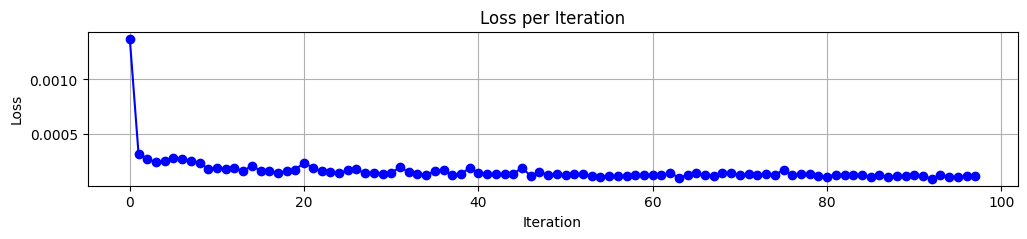

In [87]:
plt.figure(figsize=(12, 2))

# 반복 단위 손실 그래프
plt.plot(train_flatten, label='Train (per iter)', linestyle='-', marker='o', color='blue')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

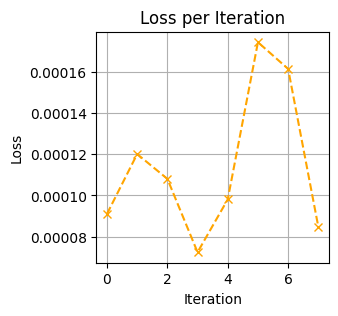

In [88]:
plt.plot(val_flatten, label='Validation (per iter)', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

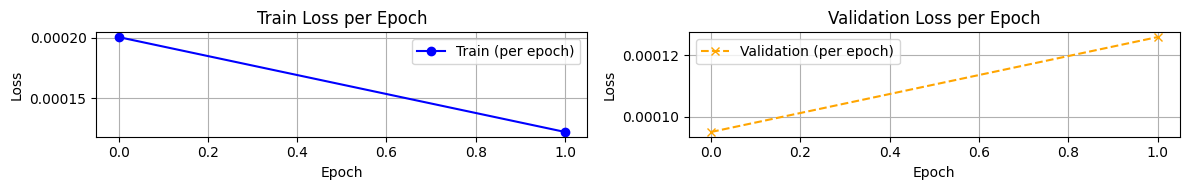

In [89]:
# 1행 2열 레이아웃 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 2))  # 그래프 크기 조정

# Train loss per epoch 그래프
axes[0].plot(train_loss_per_epoch, label='Train (per epoch)', linestyle='-', marker='o', color='blue')
axes[0].set_title("Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# Validation loss per epoch 그래프
axes[1].plot(val_loss_per_epoch, label='Validation (per epoch)', linestyle='--', marker='x', color='orange')
axes[1].set_title("Validation Loss per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

In [90]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [91]:
# cluster_id = 1
criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model_name = f'/root/cluster/c{cluster_id}/red_cnn_c{cluster_id}.pth'
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [92]:
test_path = f'/root/cluster/c{cluster_id}/whole/test_dataset.pt'
test_dataset = torch.load(test_path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

516

In [93]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  20%|██        | 104/516 [00:03<00:12, 32.54it/s]

train loss : 0.00011513230394484708


Evaluating:  40%|███▉      | 204/516 [00:06<00:09, 32.59it/s]

train loss : 9.595795625500614e-05


Evaluating:  59%|█████▉    | 304/516 [00:09<00:06, 32.51it/s]

train loss : 7.437135376676451e-05


Evaluating:  78%|███████▊  | 404/516 [00:12<00:03, 32.51it/s]

train loss : 7.352384796831757e-05


Evaluating:  98%|█████████▊| 504/516 [00:15<00:00, 32.46it/s]

train loss : 6.5916506719077e-05


Evaluating: 100%|██████████| 516/516 [00:16<00:00, 30.85it/s]


In [94]:
def rescale(normalized_img, original_min=-1000, original_max=3000):
    """
    정규화된 이미지를 원래 HU 범위로 복원하는 함수

    :param normalized_img: 정규화된 이미지 (0~1)
    :param original_min: 원본 HU 최소값
    :param original_max: 원본 HU 최대값
    :return: 원래 HU 값으로 복원된 이미지
    """
    restored_img = normalized_img * (original_max - original_min) + original_min
    return restored_img

def trans_img(X):
    return rescale(np.squeeze(X.cpu()))

def save_img(X_test, X_hat, y_test, s):
    # X_test 저장
    numpy_X_test = trans_img(X_test).numpy()
    np.save(f'X_test_image{s}.npy', numpy_X_test)
    
    # X_hat 저장
    numpy_X_hat = trans_img(X_hat).numpy()
    np.save(f'X_hat_image{s}.npy', numpy_X_hat)
    
    # y_test 저장
    numpy_y_test = trans_img(y_test).numpy()
    np.save(f'y_test_image{s}.npy', numpy_y_test)

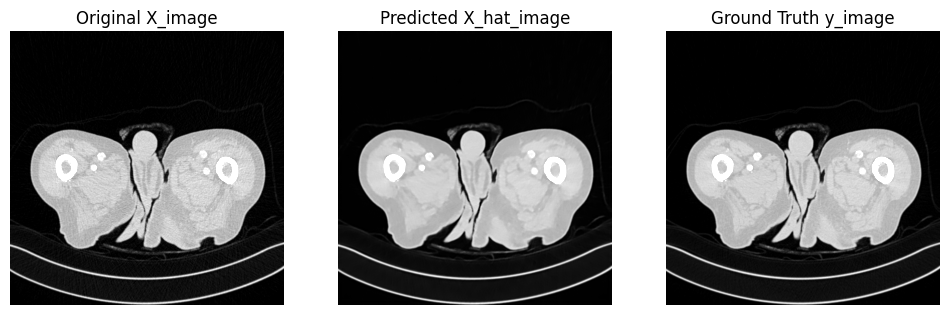

In [95]:
# 1. 가장 좋은 값 가져오기
X_test, y_test, X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
img = trans_img(X_test)
p1, p99 = np.percentile(img, (1, 99))
axes[0].imshow(img, cmap='gray', vmin=p1, vmax=p99)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
img_hat = trans_img(X_hat)
p1_hat, p99_hat = np.percentile(img_hat, (1, 99))
axes[1].imshow(img_hat, cmap='gray', vmin=p1_hat, vmax=p99_hat)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
img_y = trans_img(y_test)
p1_y, p99_y = np.percentile(img_y, (1, 99))
axes[2].imshow(img_y, cmap='gray', vmin=p1_y, vmax=p99_y)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

# 이미지 저장
save_img(X_test, X_hat, y_test, 'best')

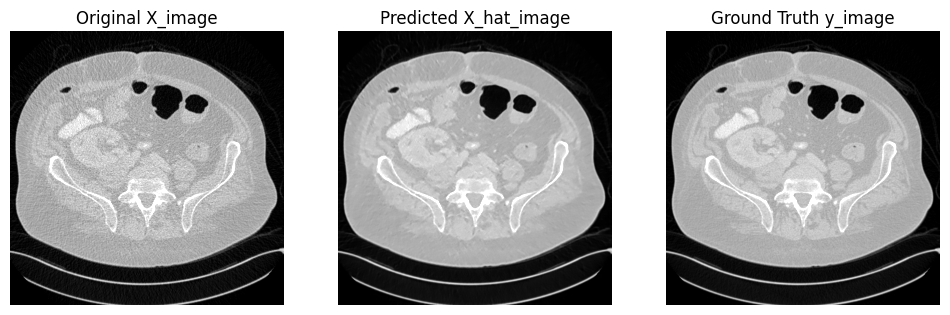

In [96]:
# 2. 가장 나쁜 값 가져오기
X_test, y_test, X_hat = worst

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
img = trans_img(X_test)
p1, p99 = np.percentile(img, (1, 99))
axes[0].imshow(img, cmap='gray', vmin=p1, vmax=p99)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
img_hat = trans_img(X_hat)
p1_hat, p99_hat = np.percentile(img_hat, (1, 99))
axes[1].imshow(img_hat, cmap='gray', vmin=p1_hat, vmax=p99_hat)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
img_y = trans_img(y_test)
p1_y, p99_y = np.percentile(img_y, (1, 99))
axes[2].imshow(img_y, cmap='gray', vmin=p1_y, vmax=p99_y)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

# 이미지 저장
save_img(X_test, X_hat, y_test, 'worst')

In [97]:
# rmse, psnr, ssim 구하기

import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
model_path = f'/root/cluster/c{cluster_id}/whole/red_cnn_c{cluster_id}.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load(model_path))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  20%|██        | 104/516 [00:04<00:18, 22.61it/s]

RMSE per interval: 0.0106, PSNR per interval: 39.66, SSIM per interval: 0.9374


Evaluating:  39%|███▉      | 203/516 [00:09<00:14, 22.30it/s]

RMSE per interval: 0.0100, PSNR per interval: 40.38, SSIM per interval: 0.9460


Evaluating:  59%|█████▊    | 302/516 [00:13<00:09, 22.37it/s]

RMSE per interval: 0.0090, PSNR per interval: 41.00, SSIM per interval: 0.9555


Evaluating:  78%|███████▊  | 404/516 [00:17<00:04, 22.61it/s]

RMSE per interval: 0.0090, PSNR per interval: 41.05, SSIM per interval: 0.9510


Evaluating:  97%|█████████▋| 503/516 [00:22<00:00, 22.47it/s]

RMSE per interval: 0.0080, PSNR per interval: 42.09, SSIM per interval: 0.9626


Evaluating: 100%|██████████| 516/516 [00:23<00:00, 21.94it/s]

Average RMSE over all intervals: 0.009311


In [98]:
import os
import numpy as np

s = f'/root/cluster/c{cluster_id}/whole/metric/'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the {s} folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the /root/cluster/c1/whole/metric/ folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


### 클러스터 2 모델 학습

In [99]:
cluster_id = 2
epochs = 2

In [100]:
# 데이터셋 불러오기

patch_folder = f"/root/cluster/c{cluster_id}/whole/"
train_path = patch_folder+'train_dataset.pt'
val_path = patch_folder+'val_dataset.pt'
test_path = patch_folder+'test_dataset.pt'

train_dataset = torch.load(train_path)
val_dataset = torch.load(val_path)
test_dataset = torch.load(test_path)

In [101]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)

(2757, 229, 293)

In [102]:
X_train, y_train = next(iter(train_loader))
X_train.shape, y_train.shape

(torch.Size([1, 1, 512, 512]), torch.Size([1, 1, 512, 512]))

In [103]:
def visualize_patches(X, y):
    fig, axes = plt.subplots(1, 2, figsize=(4, 8))  # 2행 16열로 설정

    # X 데이터 시각화
    axes[0].imshow(np.squeeze(X), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f"X", fontsize=10)
    
    # y 데이터 시각화
    axes[1].imshow(np.squeeze(y), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f"y", fontsize=10)
    
    plt.tight_layout()
    plt.show()

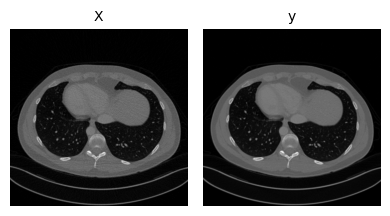

In [104]:
visualize_patches(X_train, y_train)

In [105]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [106]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)
        
        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()


    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))
        
        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결
        
        return x

In [107]:
model = RedCNN().to(device)

In [108]:
%cd /root

/root


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [109]:
import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [110]:
import torch
from tqdm import tqdm

interval = 100

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            running_loss += loss.item() * X.size(0)

            if i % interval == interval-1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                total_loss += running_loss
                running_loss = 0.0
                tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)

In [111]:
model_name = f'/root/cluster/c{cluster_id}/whole/red_cnn_c{cluster_id}'
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), f"{model_name}.pth")
        
        print('model is saving...')

Epoch 0 - Training:   4%|▎         | 102/2757 [00:09<04:07, 10.72it/s]

train loss : 0.0026284967237734237


Epoch 0 - Training:   7%|▋         | 202/2757 [00:18<03:58, 10.69it/s]

train loss : 0.000578546566539444


Epoch 0 - Training:  11%|█         | 302/2757 [00:28<03:54, 10.47it/s]

train loss : 0.00041193709141225556


Epoch 0 - Training:  15%|█▍        | 402/2757 [00:37<03:41, 10.63it/s]

train loss : 0.00032693620305508376


Epoch 0 - Training:  18%|█▊        | 502/2757 [00:47<03:32, 10.62it/s]

train loss : 0.00030016983873792924


Epoch 0 - Training:  22%|██▏       | 602/2757 [00:56<03:24, 10.53it/s]

train loss : 0.0002724149163987022


Epoch 0 - Training:  25%|██▌       | 702/2757 [01:05<03:13, 10.60it/s]

train loss : 0.00026294374925782903


Epoch 0 - Training:  29%|██▉       | 802/2757 [01:15<03:04, 10.59it/s]

train loss : 0.00025742737932887394


Epoch 0 - Training:  33%|███▎      | 902/2757 [01:24<02:55, 10.57it/s]

train loss : 0.00020512773546215612


Epoch 0 - Training:  36%|███▋      | 1002/2757 [01:34<02:45, 10.57it/s]

train loss : 0.00029705884608119957


Epoch 0 - Training:  40%|███▉      | 1102/2757 [01:43<02:36, 10.58it/s]

train loss : 0.00023016820196062327


Epoch 0 - Training:  44%|████▎     | 1202/2757 [01:53<02:26, 10.59it/s]

train loss : 0.00023611609831277746


Epoch 0 - Training:  47%|████▋     | 1302/2757 [02:02<02:17, 10.58it/s]

train loss : 0.00020660082387621514


Epoch 0 - Training:  51%|█████     | 1402/2757 [02:11<02:08, 10.58it/s]

train loss : 0.00019794461972196586


Epoch 0 - Training:  54%|█████▍    | 1502/2757 [02:21<01:58, 10.59it/s]

train loss : 0.00019982861969765507


Epoch 0 - Training:  58%|█████▊    | 1602/2757 [02:30<01:49, 10.57it/s]

train loss : 0.000192708570684772


Epoch 0 - Training:  62%|██████▏   | 1702/2757 [02:40<01:39, 10.57it/s]

train loss : 0.00019759252507355995


Epoch 0 - Training:  65%|██████▌   | 1802/2757 [02:49<01:30, 10.57it/s]

train loss : 0.00020062139687070156


Epoch 0 - Training:  69%|██████▉   | 1902/2757 [02:59<01:21, 10.52it/s]

train loss : 0.00021246790154691553


Epoch 0 - Training:  73%|███████▎  | 2002/2757 [03:08<01:11, 10.57it/s]

train loss : 0.00016789752549811965


Epoch 0 - Training:  76%|███████▌  | 2102/2757 [03:17<01:01, 10.57it/s]

train loss : 0.00019371999034774489


Epoch 0 - Training:  80%|███████▉  | 2202/2757 [03:27<00:52, 10.53it/s]

train loss : 0.00017775941083527868


Epoch 0 - Training:  83%|████████▎ | 2302/2757 [03:36<00:43, 10.56it/s]

train loss : 0.00015570695999485905


Epoch 0 - Training:  87%|████████▋ | 2402/2757 [03:46<00:33, 10.54it/s]

train loss : 0.0001904120941981091


Epoch 0 - Training:  91%|█████████ | 2502/2757 [03:55<00:24, 10.53it/s]

train loss : 0.00021096273616421968


Epoch 0 - Training:  94%|█████████▍| 2602/2757 [04:05<00:14, 10.58it/s]

train loss : 0.00016831569548230618


Epoch 0 - Training:  98%|█████████▊| 2702/2757 [04:14<00:05, 10.58it/s]

train loss : 0.0002514530131520587


Epoch 0 - Evaluating:  45%|████▌     | 104/229 [00:03<00:03, 32.05it/s]

train loss : 0.00019385671454074326


Epoch 0 - Evaluating:  89%|████████▉ | 204/229 [00:06<00:00, 32.51it/s]

train loss : 0.00017981515142309945


Epoch 0 - Evaluating: 100%|██████████| 229/229 [00:07<00:00, 29.73it/s]

Epoch [1/2], Train Loss: 0.0003, Valid Loss: 0.0002
model is saving...



Epoch 1 - Training:   4%|▎         | 102/2757 [00:09<04:11, 10.56it/s]

train loss : 0.00016735717679694062


Epoch 1 - Training:   7%|▋         | 202/2757 [00:19<04:02, 10.54it/s]

train loss : 0.00016201176429603948


Epoch 1 - Training:  11%|█         | 302/2757 [00:28<03:52, 10.55it/s]

train loss : 0.0001470537673594663


Epoch 1 - Training:  15%|█▍        | 402/2757 [00:37<03:43, 10.55it/s]

train loss : 0.00015542181416094536


Epoch 1 - Training:  18%|█▊        | 502/2757 [00:47<03:33, 10.56it/s]

train loss : 0.0001738556276905001


Epoch 1 - Training:  22%|██▏       | 602/2757 [00:56<03:24, 10.55it/s]

train loss : 0.00016854006971698255


Epoch 1 - Training:  25%|██▌       | 702/2757 [01:06<03:14, 10.55it/s]

train loss : 0.000162412860445329


Epoch 1 - Training:  29%|██▉       | 802/2757 [01:15<03:05, 10.57it/s]

train loss : 0.00020137367446295684


Epoch 1 - Training:  33%|███▎      | 902/2757 [01:25<02:55, 10.56it/s]

train loss : 0.0001685211787116714


Epoch 1 - Training:  36%|███▋      | 1002/2757 [01:34<02:46, 10.55it/s]

train loss : 0.00016199622365093092


Epoch 1 - Training:  40%|███▉      | 1102/2757 [01:44<02:36, 10.55it/s]

train loss : 0.000160181566789106


Epoch 1 - Training:  44%|████▎     | 1202/2757 [01:53<02:27, 10.54it/s]

train loss : 0.0001465602911048336


Epoch 1 - Training:  47%|████▋     | 1302/2757 [02:03<02:17, 10.55it/s]

train loss : 0.00017432906071917386


Epoch 1 - Training:  51%|█████     | 1402/2757 [02:12<02:08, 10.54it/s]

train loss : 0.00015704463203292107


Epoch 1 - Training:  54%|█████▍    | 1502/2757 [02:21<01:59, 10.54it/s]

train loss : 0.00018055106138490374


Epoch 1 - Training:  58%|█████▊    | 1602/2757 [02:31<01:49, 10.54it/s]

train loss : 0.00015654207920306362


Epoch 1 - Training:  62%|██████▏   | 1702/2757 [02:40<01:39, 10.58it/s]

train loss : 0.00018781991271680455


Epoch 1 - Training:  65%|██████▌   | 1802/2757 [02:50<01:30, 10.55it/s]

train loss : 0.00016746215009334265


Epoch 1 - Training:  69%|██████▉   | 1902/2757 [02:59<01:21, 10.55it/s]

train loss : 0.0001816262403735891


Epoch 1 - Training:  73%|███████▎  | 2002/2757 [03:09<01:11, 10.55it/s]

train loss : 0.00017535108228912576


Epoch 1 - Training:  76%|███████▌  | 2102/2757 [03:18<01:02, 10.55it/s]

train loss : 0.00015754203166579828


Epoch 1 - Training:  80%|███████▉  | 2202/2757 [03:28<00:52, 10.57it/s]

train loss : 0.00014321752943942555


Epoch 1 - Training:  83%|████████▎ | 2302/2757 [03:37<00:43, 10.54it/s]

train loss : 0.00018859739295294276


Epoch 1 - Training:  87%|████████▋ | 2402/2757 [03:47<00:33, 10.55it/s]

train loss : 0.00014331348040286685


Epoch 1 - Training:  91%|█████████ | 2502/2757 [03:56<00:24, 10.56it/s]

train loss : 0.00017609746944799554


Epoch 1 - Training:  94%|█████████▍| 2602/2757 [04:05<00:14, 10.55it/s]

train loss : 0.00014476717195066157


Epoch 1 - Training:  98%|█████████▊| 2702/2757 [04:15<00:05, 10.54it/s]

train loss : 0.00013987382288178197


Epoch 1 - Evaluating:  45%|████▌     | 104/229 [00:03<00:03, 32.40it/s]

train loss : 0.00016876875608431874


Epoch 1 - Evaluating:  89%|████████▉ | 204/229 [00:06<00:00, 32.37it/s]

train loss : 0.00016751322356867604


Epoch 1 - Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.58it/s]

Epoch [2/2], Train Loss: 0.0002, Valid Loss: 0.0001
model is saving...


In [112]:
!pwd

/root


In [113]:
%cd '/root/cluster/c{cluster_id}/whole'

/root/cluster/c2/whole


In [114]:
!pwd

/root/cluster/c2/whole


In [115]:
import pickle

data_to_save = {
    'train_loss_per_iter': train_loss_per_iter,
    'val_loss_per_iter': val_loss_per_iter,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch
}

for filename, data in data_to_save.items():
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [116]:
import pickle

filenames = [
    'train_loss_per_iter.pkl',
    'val_loss_per_iter.pkl',
    'train_loss_per_epoch.pkl',
    'val_loss_per_epoch.pkl'
]

variables = [
    'train_loss_per_iter',
    'val_loss_per_iter',
    'train_loss_per_epoch',
    'val_loss_per_epoch'
]

data_to_load = dict(zip(filenames, variables))

for filename, variable_name in data_to_load.items():
    with open(filename, 'rb') as f:
        globals()[variable_name] = pickle.load(f)

In [117]:
train_flatten, val_flatten = [item for sublist in train_loss_per_iter for item in sublist], [item for sublist in val_loss_per_iter for item in sublist]

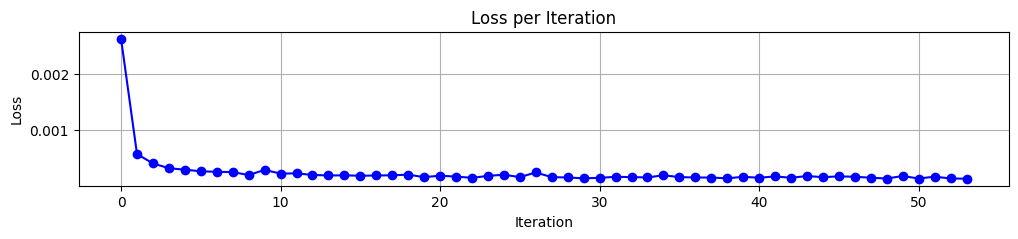

In [118]:
plt.figure(figsize=(12, 2))

# 반복 단위 손실 그래프
plt.plot(train_flatten, label='Train (per iter)', linestyle='-', marker='o', color='blue')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

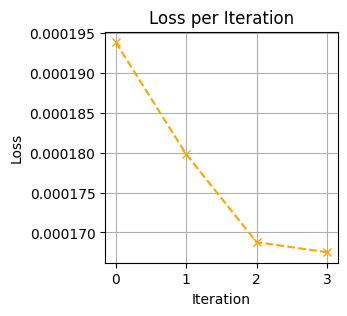

In [119]:
plt.plot(val_flatten, label='Validation (per iter)', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

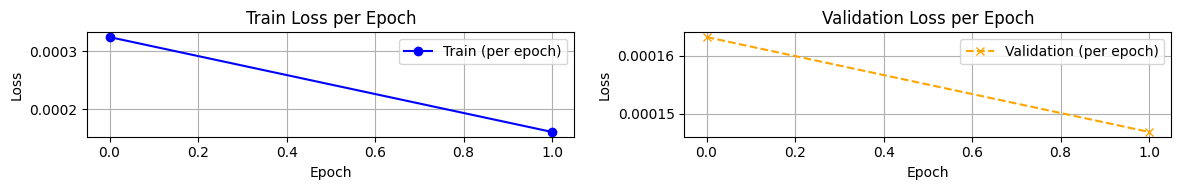

In [120]:
# 1행 2열 레이아웃 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 2))  # 그래프 크기 조정

# Train loss per epoch 그래프
axes[0].plot(train_loss_per_epoch, label='Train (per epoch)', linestyle='-', marker='o', color='blue')
axes[0].set_title("Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# Validation loss per epoch 그래프
axes[1].plot(val_loss_per_epoch, label='Validation (per epoch)', linestyle='--', marker='x', color='orange')
axes[1].set_title("Validation Loss per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

In [121]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [122]:
# cluster_id = 2
criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model_name = f'/root/cluster/c{cluster_id}/red_cnn_c{cluster_id}.pth'
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [123]:
test_path = f'/root/cluster/c{cluster_id}/whole/test_dataset.pt'
test_dataset = torch.load(test_path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

293

In [124]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  35%|███▌      | 104/293 [00:03<00:05, 32.47it/s]

train loss : 9.417803463293239e-05


Evaluating:  70%|██████▉   | 204/293 [00:06<00:02, 32.40it/s]

train loss : 0.00012051128740495187


Evaluating: 100%|██████████| 293/293 [00:09<00:00, 30.43it/s]


In [125]:
def rescale(normalized_img, original_min=-1000, original_max=3000):
    """
    정규화된 이미지를 원래 HU 범위로 복원하는 함수

    :param normalized_img: 정규화된 이미지 (0~1)
    :param original_min: 원본 HU 최소값
    :param original_max: 원본 HU 최대값
    :return: 원래 HU 값으로 복원된 이미지
    """
    restored_img = normalized_img * (original_max - original_min) + original_min
    return restored_img

def trans_img(X):
    return rescale(np.squeeze(X.cpu()))

def save_img(X_test, X_hat, y_test, s):
    # X_test 저장
    numpy_X_test = trans_img(X_test).numpy()
    np.save(f'X_test_image{s}.npy', numpy_X_test)
    
    # X_hat 저장
    numpy_X_hat = trans_img(X_hat).numpy()
    np.save(f'X_hat_image{s}.npy', numpy_X_hat)
    
    # y_test 저장
    numpy_y_test = trans_img(y_test).numpy()
    np.save(f'y_test_image{s}.npy', numpy_y_test)

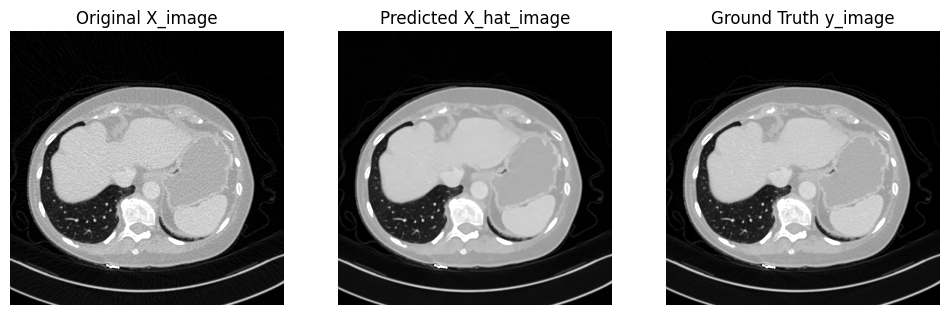

In [126]:
# 1. 가장 좋은 값 가져오기
X_test, y_test, X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
img = trans_img(X_test)
p1, p99 = np.percentile(img, (1, 99))
axes[0].imshow(img, cmap='gray', vmin=p1, vmax=p99)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
img_hat = trans_img(X_hat)
p1_hat, p99_hat = np.percentile(img_hat, (1, 99))
axes[1].imshow(img_hat, cmap='gray', vmin=p1_hat, vmax=p99_hat)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
img_y = trans_img(y_test)
p1_y, p99_y = np.percentile(img_y, (1, 99))
axes[2].imshow(img_y, cmap='gray', vmin=p1_y, vmax=p99_y)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

# 이미지 저장
save_img(X_test, X_hat, y_test, 'best')

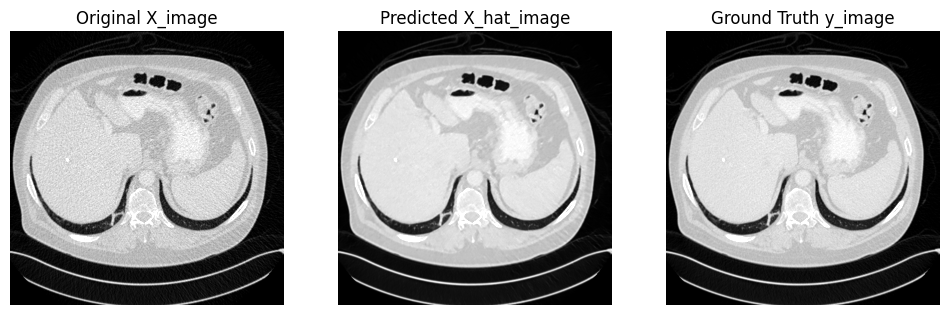

In [127]:
# 2. 가장 나쁜 값 가져오기
X_test, y_test, X_hat = worst

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
img = trans_img(X_test)
p1, p99 = np.percentile(img, (1, 99))
axes[0].imshow(img, cmap='gray', vmin=p1, vmax=p99)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
img_hat = trans_img(X_hat)
p1_hat, p99_hat = np.percentile(img_hat, (1, 99))
axes[1].imshow(img_hat, cmap='gray', vmin=p1_hat, vmax=p99_hat)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
img_y = trans_img(y_test)
p1_y, p99_y = np.percentile(img_y, (1, 99))
axes[2].imshow(img_y, cmap='gray', vmin=p1_y, vmax=p99_y)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

# 이미지 저장
save_img(X_test, X_hat, y_test, 'worst')

In [128]:
# rmse, psnr, ssim 구하기

import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 100

# 저장된 모델 로드
model_path = f'/root/cluster/c{cluster_id}/whole/red_cnn_c{cluster_id}.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load(model_path))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  35%|███▌      | 104/293 [00:04<00:08, 22.37it/s]

RMSE per interval: 0.0131, PSNR per interval: 37.80, SSIM per interval: 0.9330


Evaluating:  69%|██████▉   | 203/293 [00:09<00:04, 22.34it/s]

RMSE per interval: 0.0134, PSNR per interval: 37.75, SSIM per interval: 0.9320


Evaluating: 100%|██████████| 293/293 [00:13<00:00, 21.44it/s]

Average RMSE over all intervals: 0.013256


In [129]:
import os
import numpy as np

s = f'/root/cluster/c{cluster_id}/whole/metric/'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the {s} folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the /root/cluster/c2/whole/metric/ folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 모델 비교

In [130]:
!pwd

/root/cluster/c2/whole


In [131]:
%cd /root

/root


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/tmp/ipykernel_433/340467050.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/tmp/ipykernel_433/340467050.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/tmp/ipykernel_433/340467050.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')


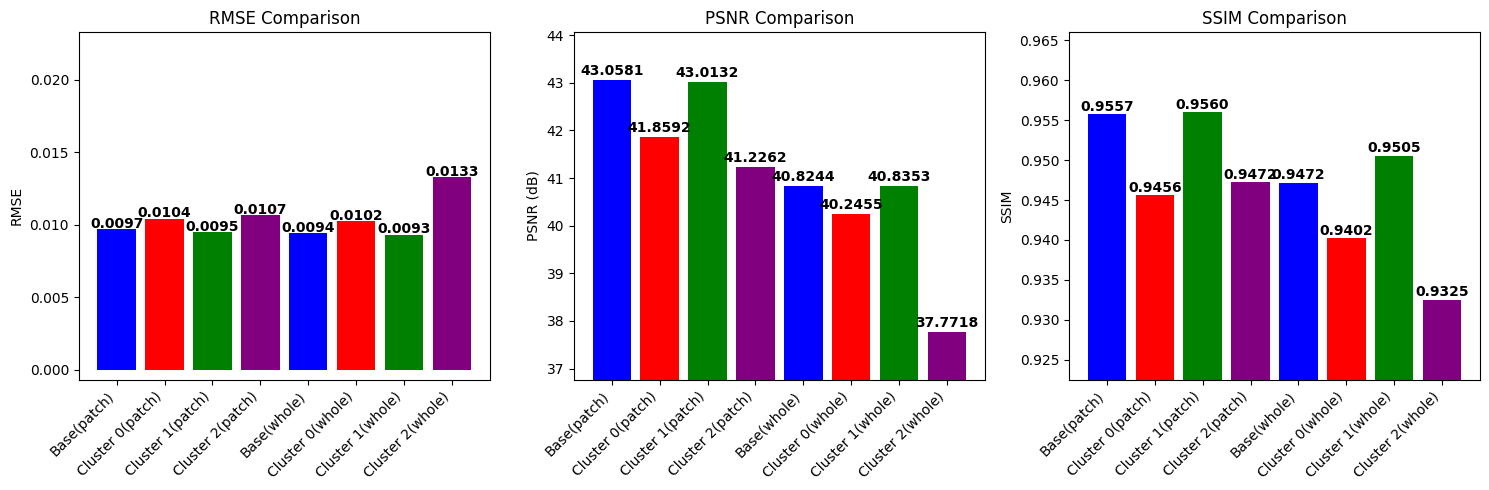

In [132]:
import numpy as np
import matplotlib.pyplot as plt

# 모델별 메트릭 파일 경로
metric_path_list = [
    '/root/base/metric',
    '/root/cluster/c0/metric',
    '/root/cluster/c1/metric',
    '/root/cluster/c2/metric',
    
    '/root/base/whole/metric',
    '/root/cluster/c0/whole/metric',
    '/root/cluster/c1/whole/metric',
    '/root/cluster/c2/whole/metric'
]

# 파일 이름 리스트
file_name_list = ['loss_list.npy', 'psnr_list.npy', 'ssim_list.npy']

# 모델별 이름
model_names = [
    'Base(patch)', 'Cluster 0(patch)', 'Cluster 1(patch)', 'Cluster 2(patch)',
    'Base(whole)', 'Cluster 0(whole)', 'Cluster 1(whole)', 'Cluster 2(whole)'
]

colors = ['blue', 'red', 'green', 'purple'] * 2

# RMSE, PSNR, SSIM 저장 리스트
rmse_list, psnr_list, ssim_list = [], [], []

# 각 모델의 메트릭 계산
for path in metric_path_list:
    rmse = np.mean(np.load(f'{path}/{file_name_list[0]}'))
    psnr = np.mean(np.load(f'{path}/{file_name_list[1]}'))
    ssim = np.mean(np.load(f'{path}/{file_name_list[2]}'))

    rmse_list.append(rmse)
    psnr_list.append(psnr)
    ssim_list.append(ssim)

# Y축 범위 설정 (차이를 두드러지게)
rmse_min, rmse_max = min(rmse_list) - 0.01, max(rmse_list) + 0.01
psnr_min, psnr_max = min(psnr_list) - 1, max(psnr_list) + 1
ssim_min, ssim_max = min(ssim_list) - 0.01, max(ssim_list) + 0.01

# 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 비교 (낮을수록 좋음)
axes[0].bar(model_names, rmse_list, color=colors)
axes[0].set_title('RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].set_ylim(rmse_min, rmse_max)

# PSNR 비교 (높을수록 좋음)
axes[1].bar(model_names, psnr_list, color=colors)
axes[1].set_title('PSNR Comparison')
axes[1].set_ylabel('PSNR (dB)')
axes[1].set_ylim(psnr_min, psnr_max)

# SSIM 비교 (높을수록 좋음)
axes[2].bar(model_names, ssim_list, color=colors)
axes[2].set_title('SSIM Comparison')
axes[2].set_ylabel('SSIM')
axes[2].set_ylim(ssim_min, ssim_max)

# X축 라벨 45도 회전하여 겹침 방지
for ax in axes:
    ax.set_xticklabels(model_names, rotation=45, ha='right')

# 막대 위에 수치 추가 (위로 띄우기)
for i, ax in enumerate(axes):
    values = [rmse_list, psnr_list, ssim_list][i]
    y_offset = (max(values) - min(values)) * 0.02  # 막대 높이에 따라 동적 조정
    for j, v in enumerate(values):
        ax.text(j, v + y_offset, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipykernel_433/169863362.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/tmp/ipykernel_433/169863362.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/tmp/ipykernel_433/169863362.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')


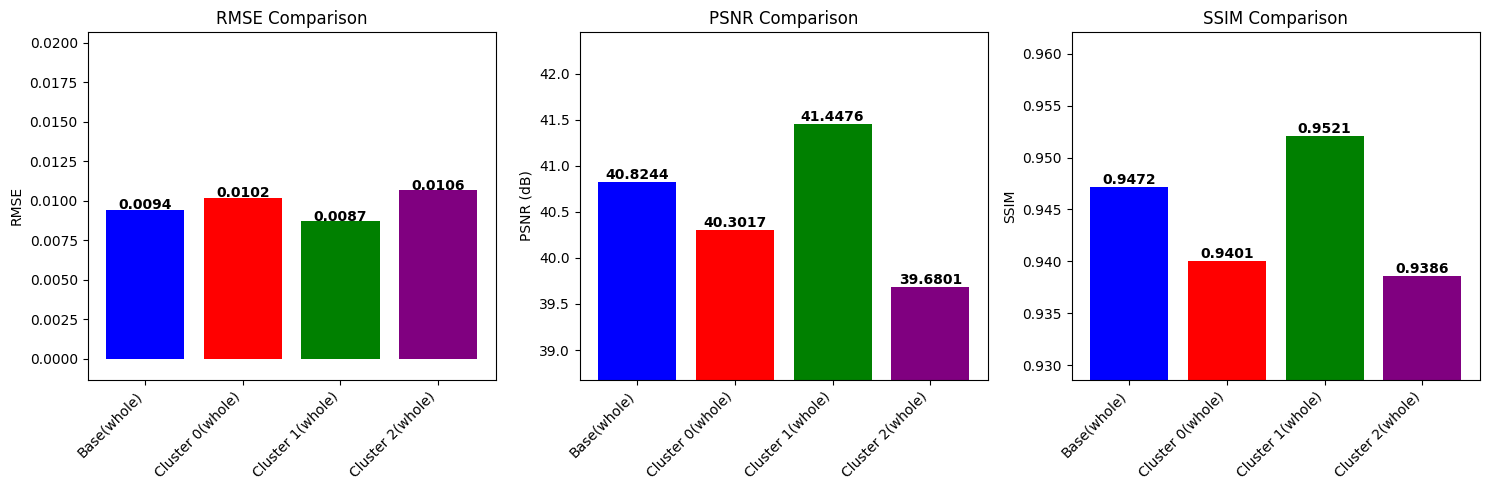

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# 모델별 메트릭 파일 경로
metric_path_list = [
    
    '/root/base/whole/metric',
    '/root/base/whole/c0/metric',
    '/root/base/whole/c1/metric',
    '/root/base/whole/c2/metric'

]

# 파일 이름 리스트
file_name_list = ['loss_list.npy', 'psnr_list.npy', 'ssim_list.npy']

# 모델별 이름
model_names = [
    'Base(whole)', 'Cluster 0(whole)', 'Cluster 1(whole)', 'Cluster 2(whole)',
]

colors = ['blue', 'red', 'green', 'purple'] * 2

# RMSE, PSNR, SSIM 저장 리스트
rmse_list, psnr_list, ssim_list = [], [], []

# 각 모델의 메트릭 계산
for path in metric_path_list:
    rmse = np.mean(np.load(f'{path}/{file_name_list[0]}'))
    psnr = np.mean(np.load(f'{path}/{file_name_list[1]}'))
    ssim = np.mean(np.load(f'{path}/{file_name_list[2]}'))

    rmse_list.append(rmse)
    psnr_list.append(psnr)
    ssim_list.append(ssim)

# Y축 범위 설정 (차이를 두드러지게)
rmse_min, rmse_max = min(rmse_list) - 0.01, max(rmse_list) + 0.01
psnr_min, psnr_max = min(psnr_list) - 1, max(psnr_list) + 1
ssim_min, ssim_max = min(ssim_list) - 0.01, max(ssim_list) + 0.01

# 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 비교 (낮을수록 좋음)
axes[0].bar(model_names, rmse_list, color=colors)
axes[0].set_title('RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].set_ylim(rmse_min, rmse_max)

# PSNR 비교 (높을수록 좋음)
axes[1].bar(model_names, psnr_list, color=colors)
axes[1].set_title('PSNR Comparison')
axes[1].set_ylabel('PSNR (dB)')
axes[1].set_ylim(psnr_min, psnr_max)

# SSIM 비교 (높을수록 좋음)
axes[2].bar(model_names, ssim_list, color=colors)
axes[2].set_title('SSIM Comparison')
axes[2].set_ylabel('SSIM')
axes[2].set_ylim(ssim_min, ssim_max)

# X축 라벨 45도 회전하여 겹침 방지
for ax in axes:
    ax.set_xticklabels(model_names, rotation=45, ha='right')

# 막대 위에 수치 추가 (위로 띄우기)
for i, ax in enumerate(axes):
    values = [rmse_list, psnr_list, ssim_list][i]
    y_offset = (max(values) - min(values)) * 0.02  # 막대 높이에 따라 동적 조정
    for j, v in enumerate(values):
        ax.text(j, v + y_offset, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()